In [6]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [7]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [8]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 100

In [9]:
with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{122}subjs_5.pkl','rb') as f:
        model1,q1,elbos1,resampled_subj_list = pickle.load(f)

resampled_df = []
for pid in resampled_subj_list:
    resampled_df.append(orig_df[orig_df['pid']==pid])
resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

df1 = resampled_df

df1['continuous_states'] = [None]*df1.shape[0]
df1['discrete_states'] =[None]*df1.shape[0]
hrflag=0
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
for idx_row in range(df1.shape[0]):
    prox = df1.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1-np.digitize(df1.loc[idx_row]['direction'], bins=dir_bins)
    stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
    input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

    y = df1.loc[idx_row]['timeseries']
    x = q1.mean_continuous_states[idx_row]
    z = model1.most_likely_states(x,y,input=input)
    df1.at[idx_row,'continuous_states'] = x
    df1.at[idx_row,'discrete_states'] = z
    prox = df1.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df1.at[idx_row,'proximity'] = prox

pid 001
pid 002
pid 003
pid 004
pid 005
pid 006
pid 007
pid 008
pid 009
pid 010
pid 011
pid 012
pid 013
pid 014
pid 015
pid 016
pid 017
pid 018
pid 019
pid 020
pid 021
pid 022
pid 023
pid 024
pid 025
pid 026
pid 027
pid 028
pid 029
pid 030
pid 031
pid 032
pid 033
pid 034
pid 035
pid 036
pid 037
pid 038
pid 039
pid 040
pid 041
pid 042
pid 043
pid 044
pid 045
pid 046
pid 047
pid 048
pid 049
pid 050
pid 051
pid 052
pid 053
pid 054
pid 055
pid 056
pid 057
pid 058
pid 059
pid 060
pid 061
pid 062
pid 063
pid 064
pid 065
pid 066
pid 067
pid 068
pid 069
pid 071
pid 072
pid 073
pid 074
pid 075
pid 076
pid 077
pid 078
pid 079
pid 080
pid 081
pid 082
pid 083
pid 084
pid 085
pid 086
pid 087
pid 088
pid 089
pid 090
pid 091
pid 092
pid 093
pid 094
pid 095
pid 096
pid 097
pid 098
pid 099
pid 101
pid 102
pid 103
pid 104
pid 105
pid 106
pid 107
pid 108
pid 109
pid 110
pid 111
pid 112
pid 113
pid 114
pid 115
pid 116
pid 117
pid 118
pid 119
pid 120
pid 121
pid 122
pid 123
pid 125


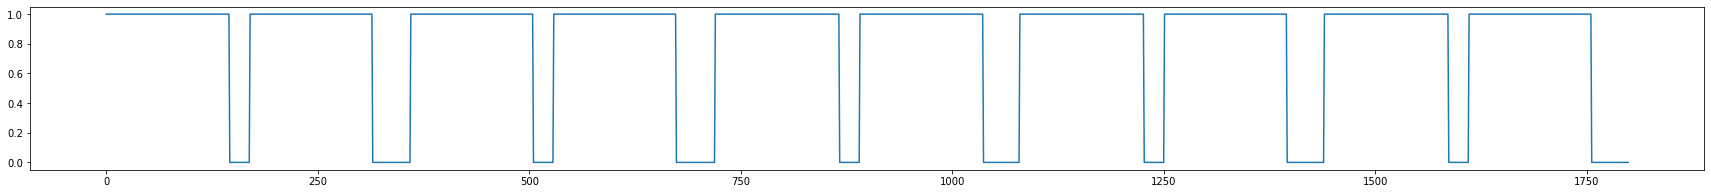

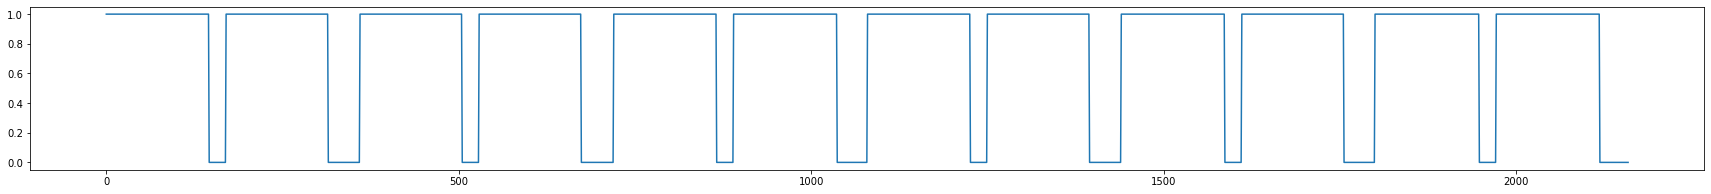

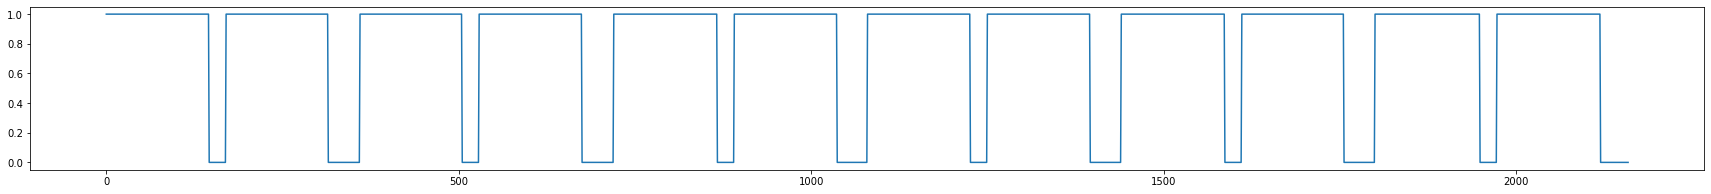

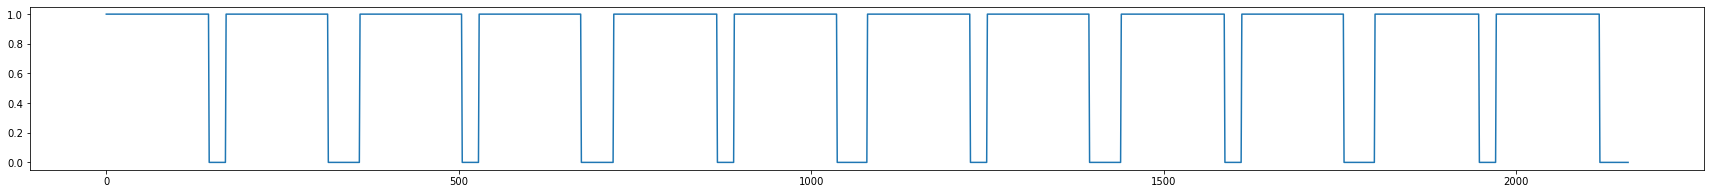

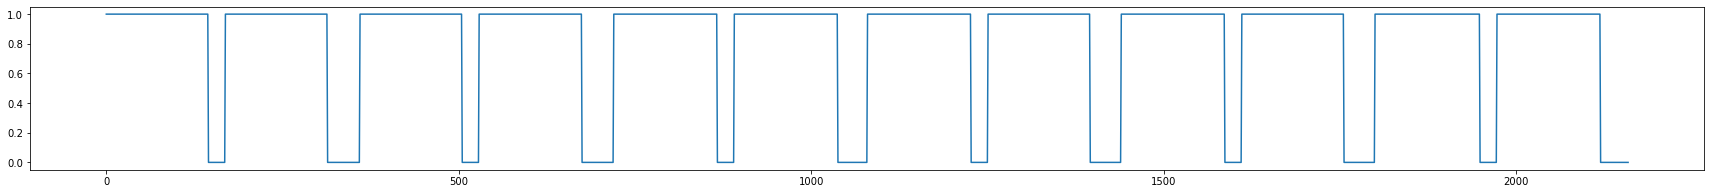

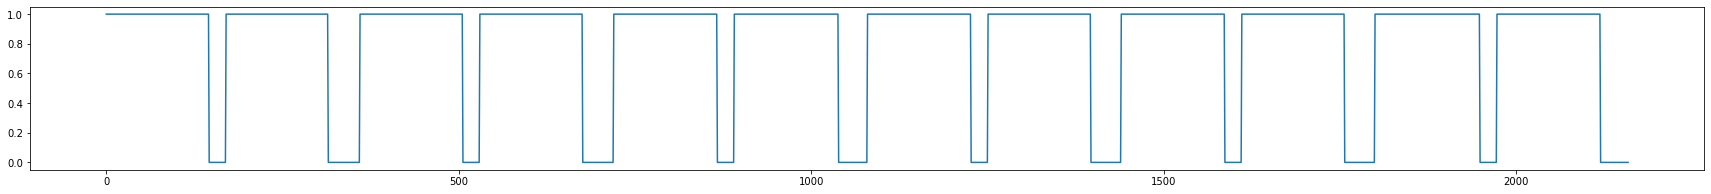

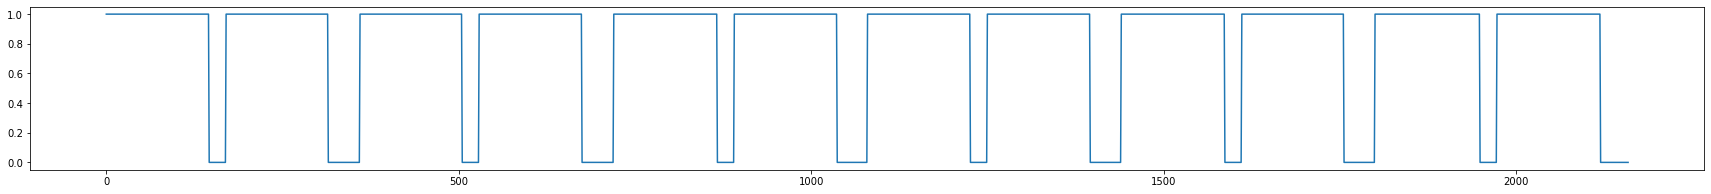

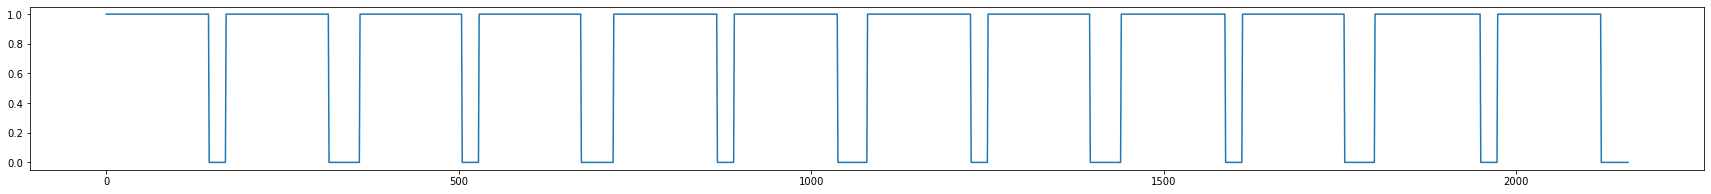

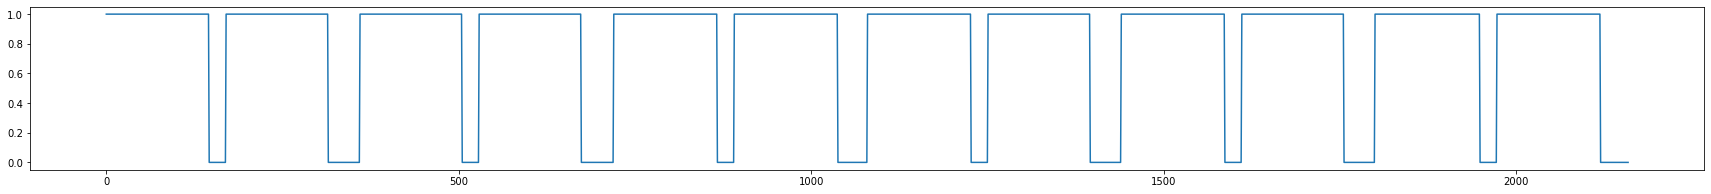

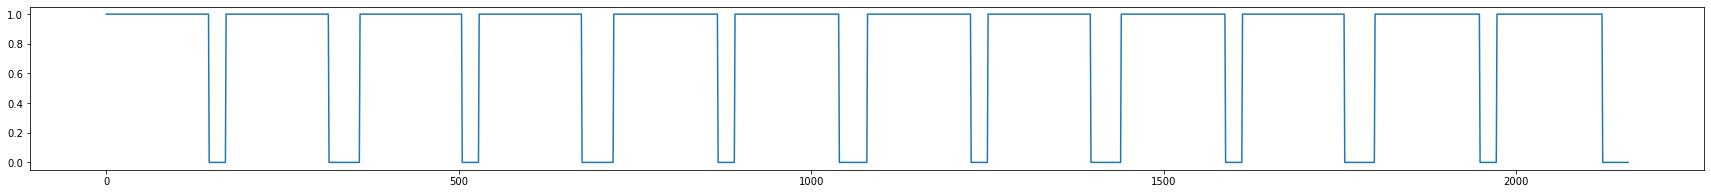

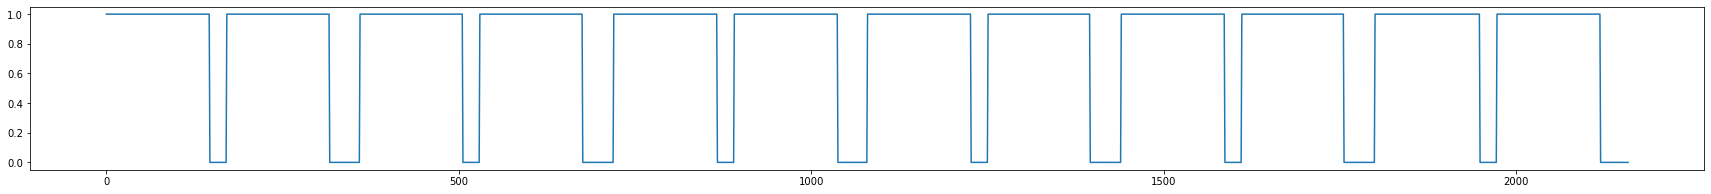

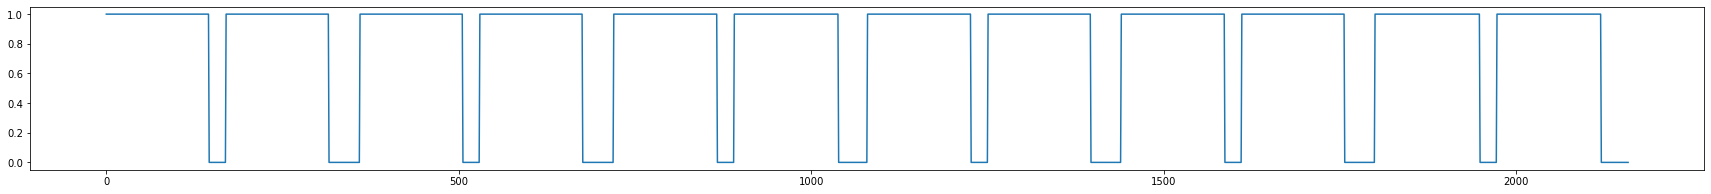

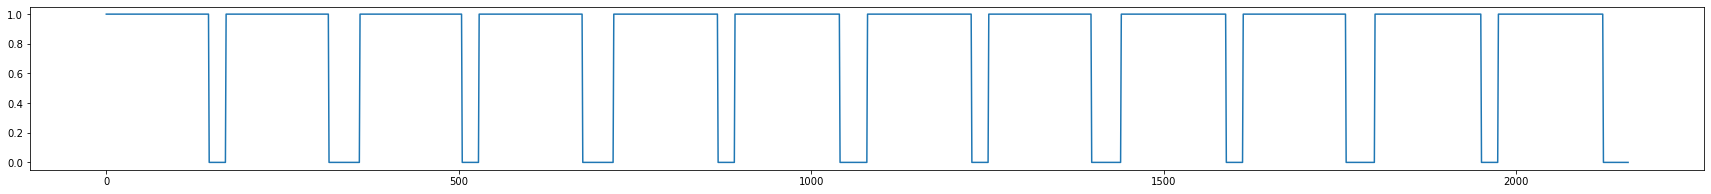

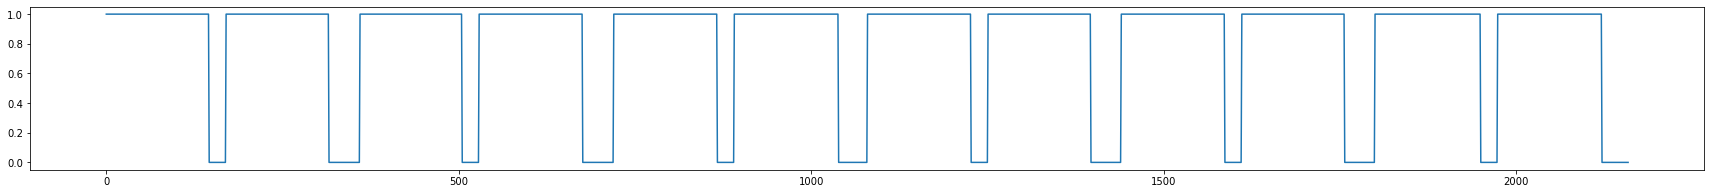

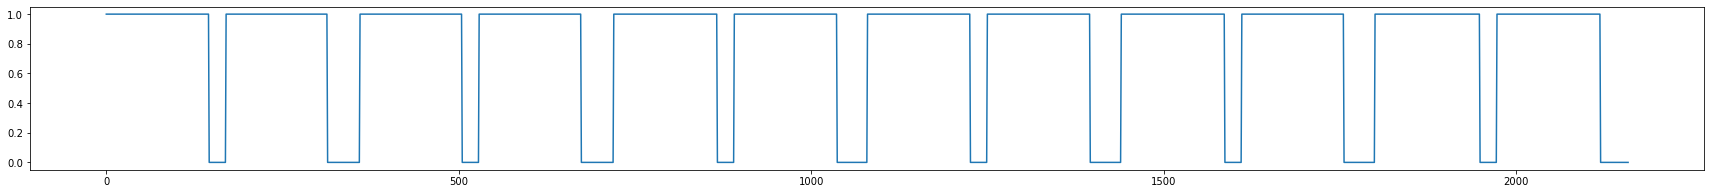

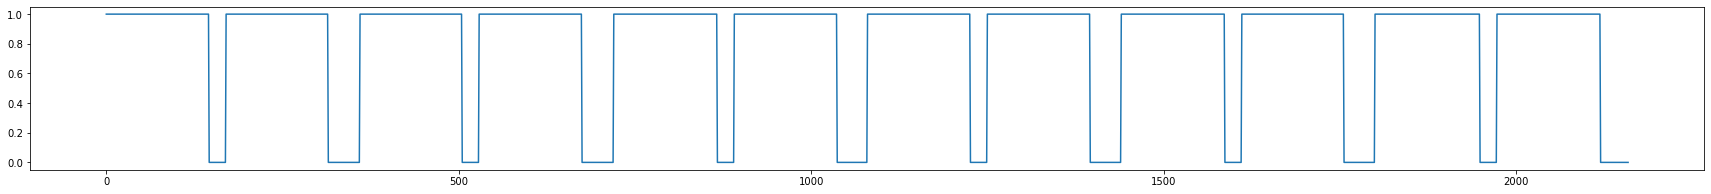

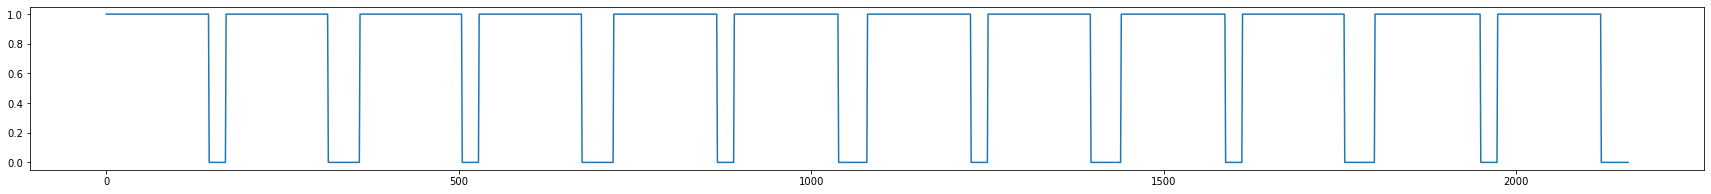

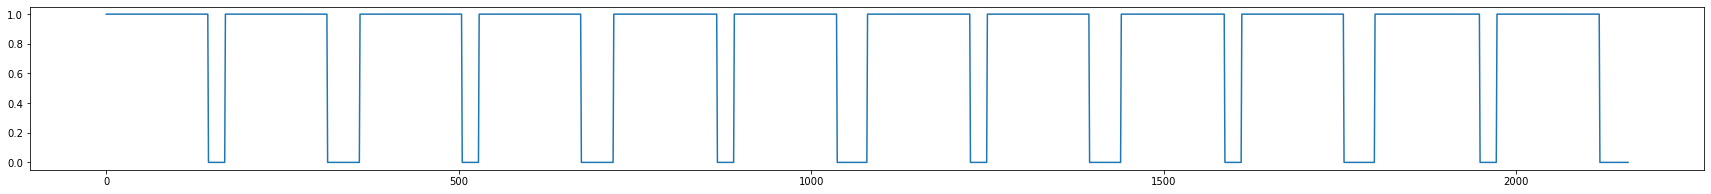

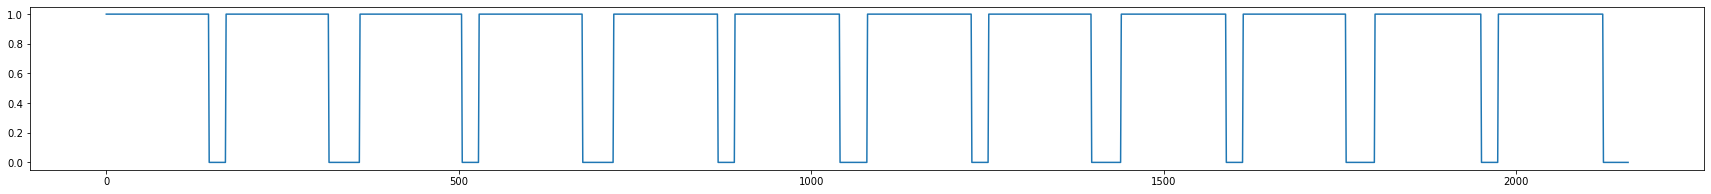

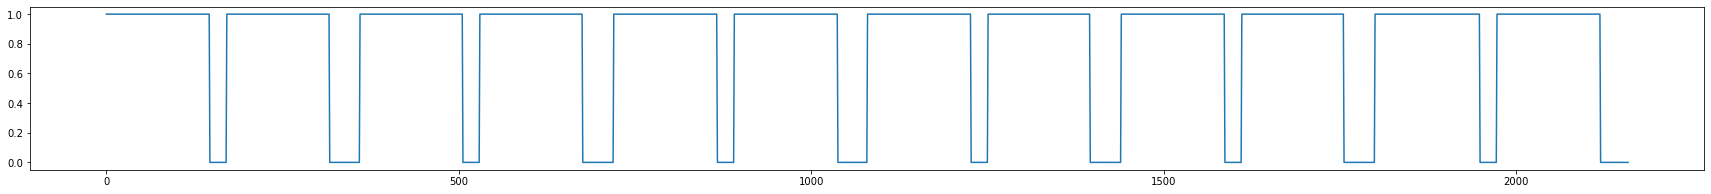

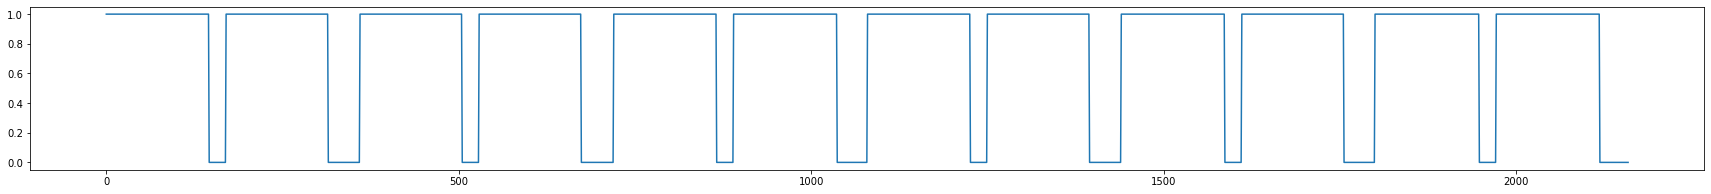

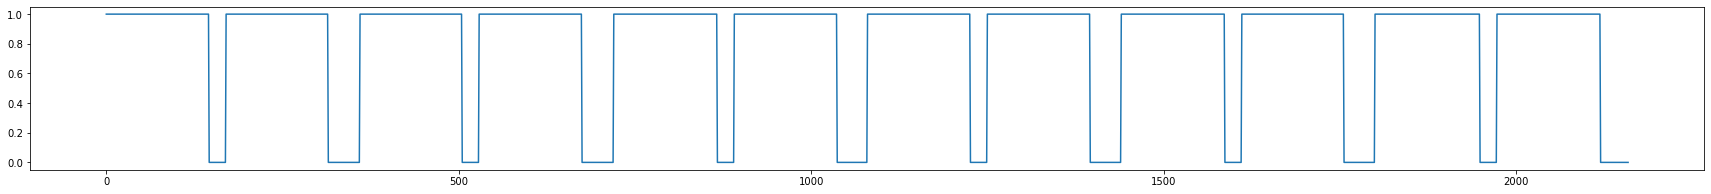

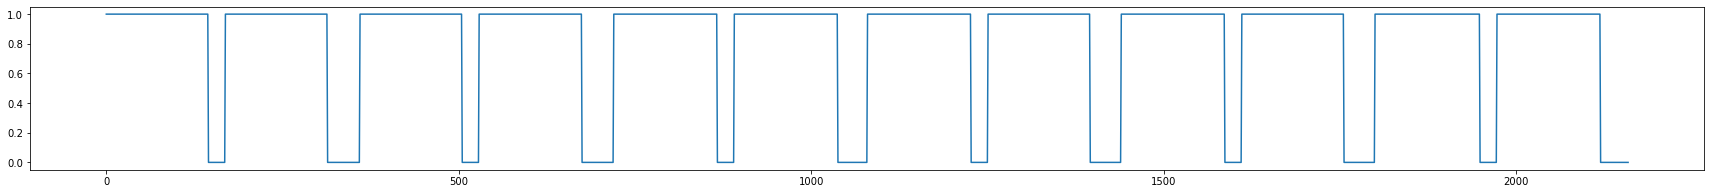

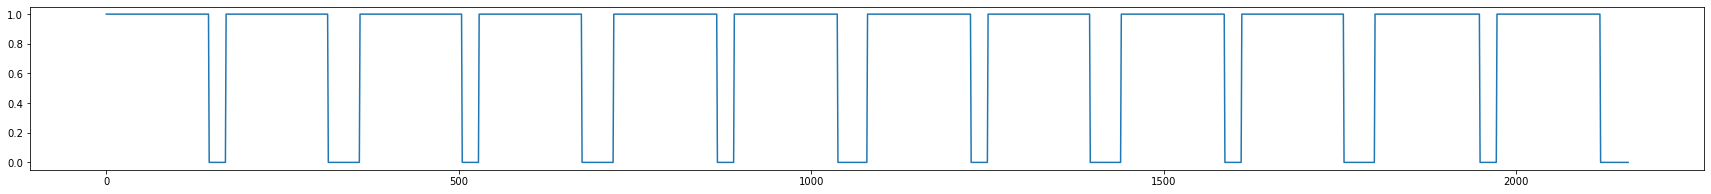

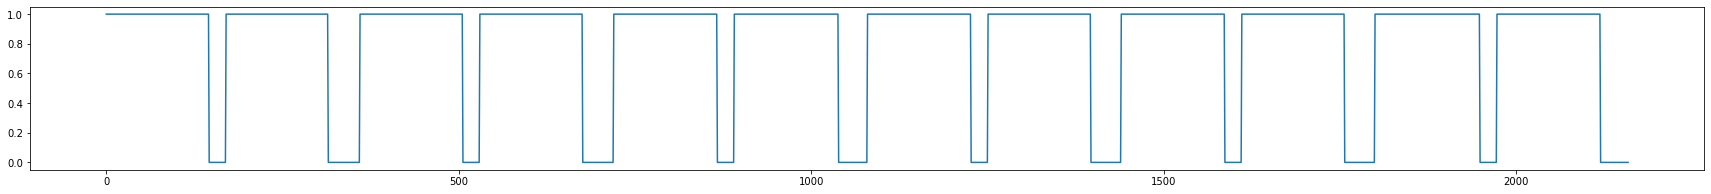

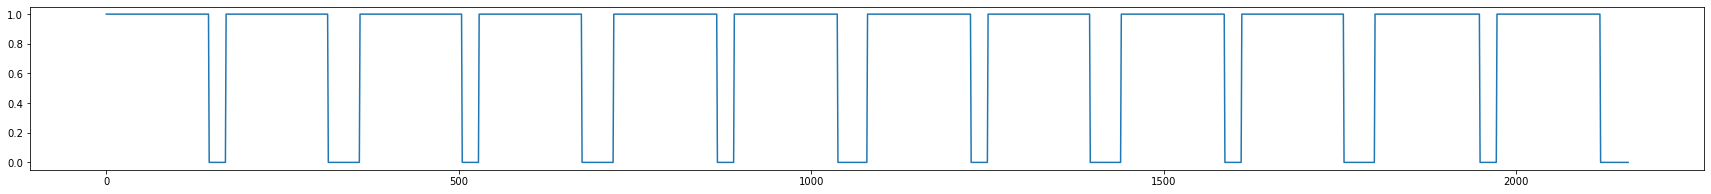

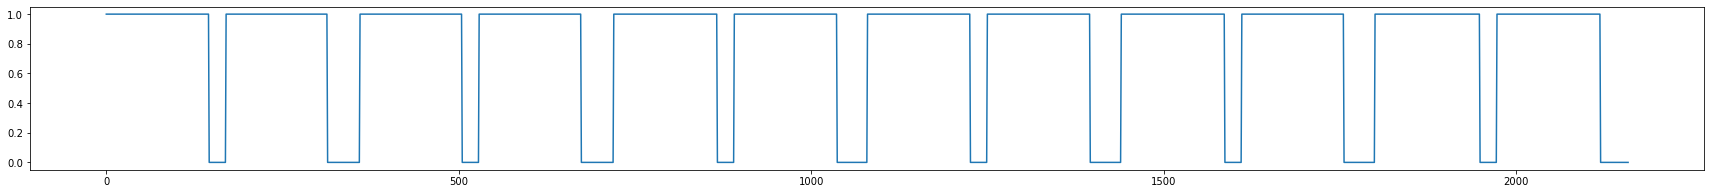

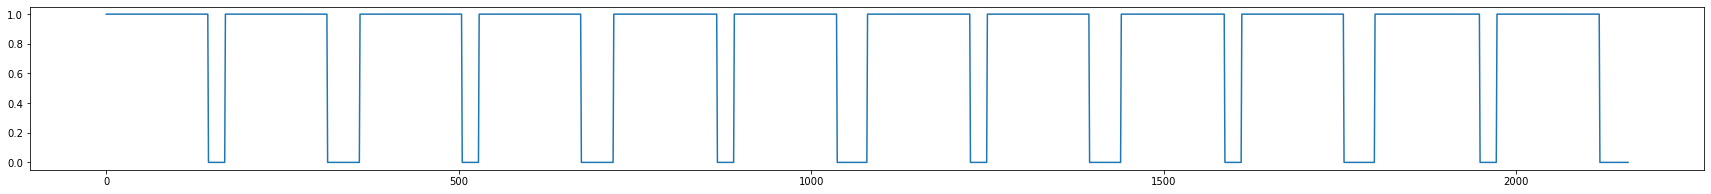

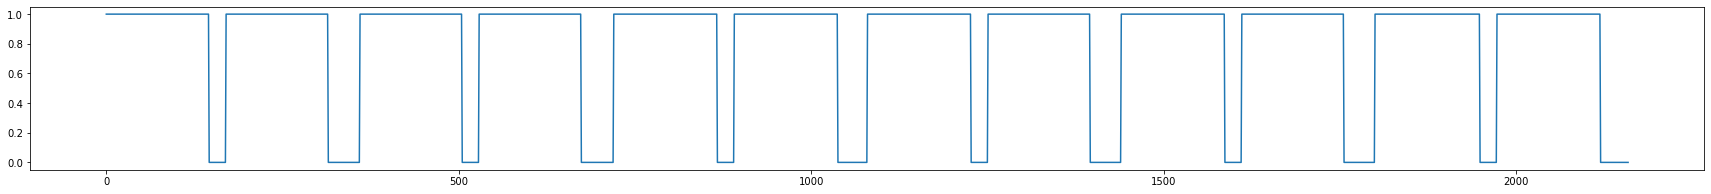

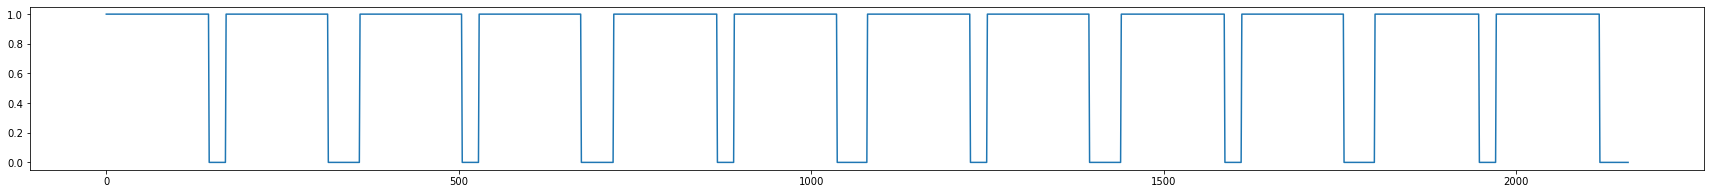

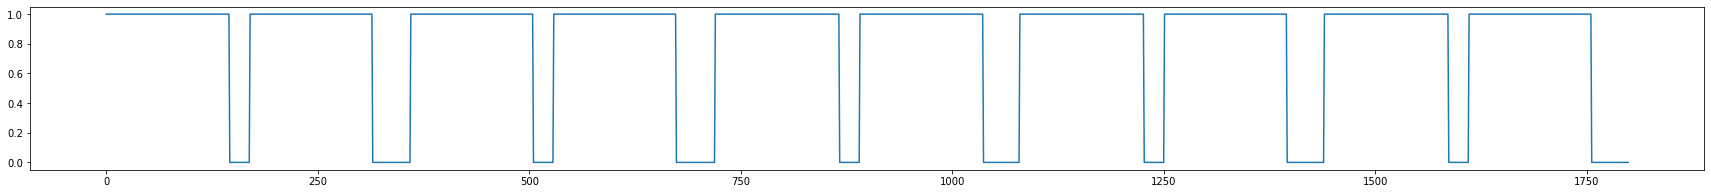

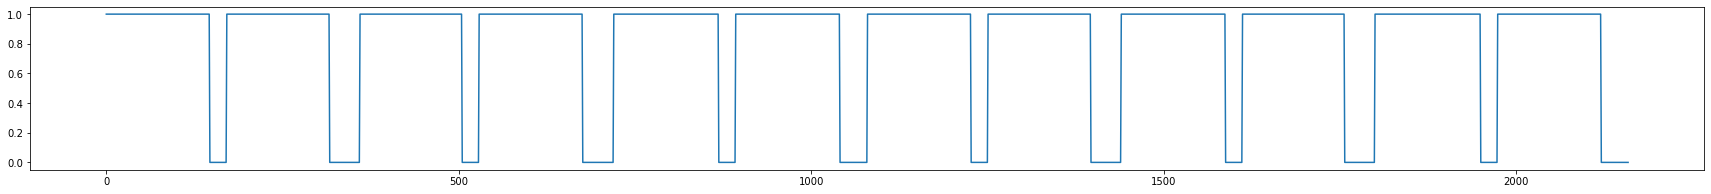

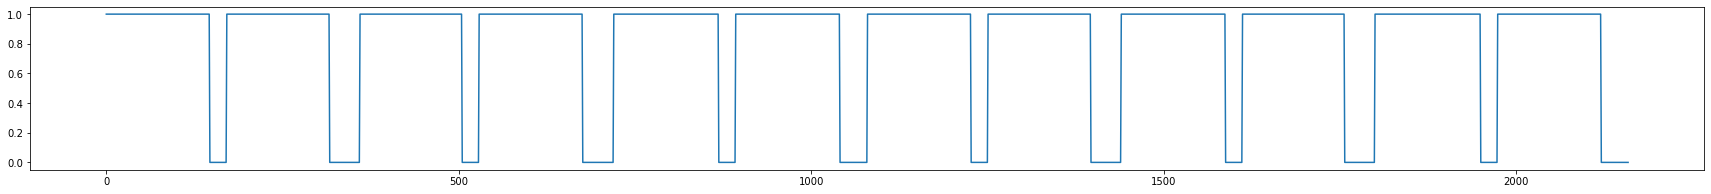

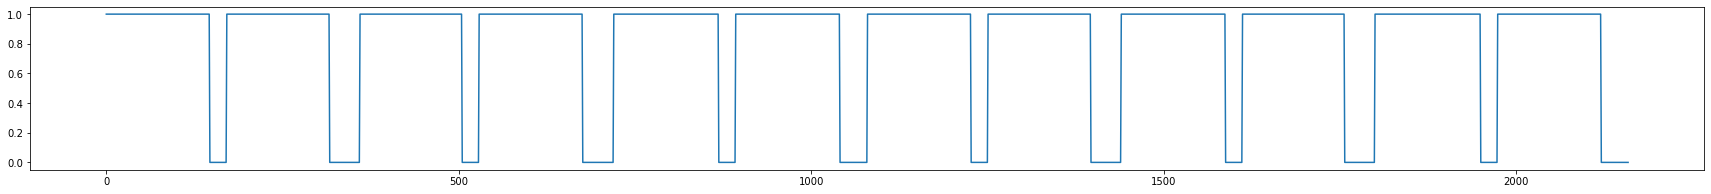

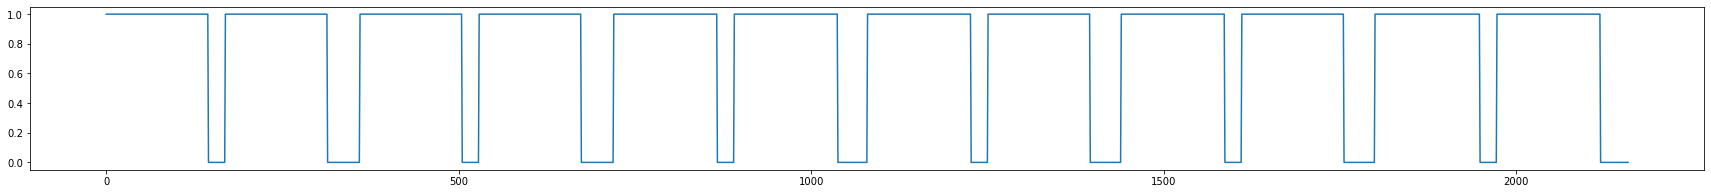

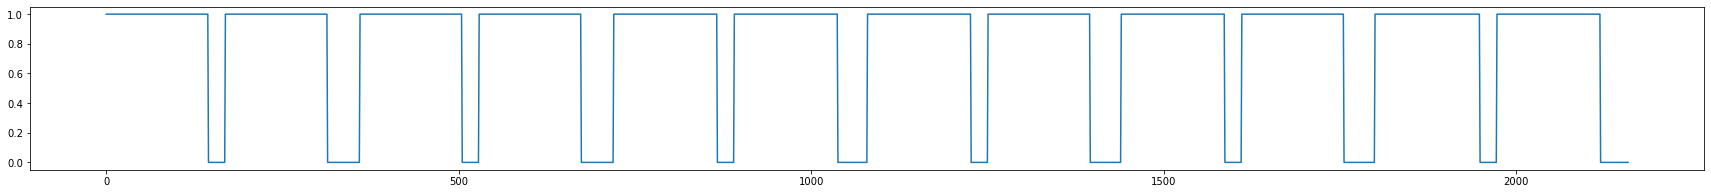

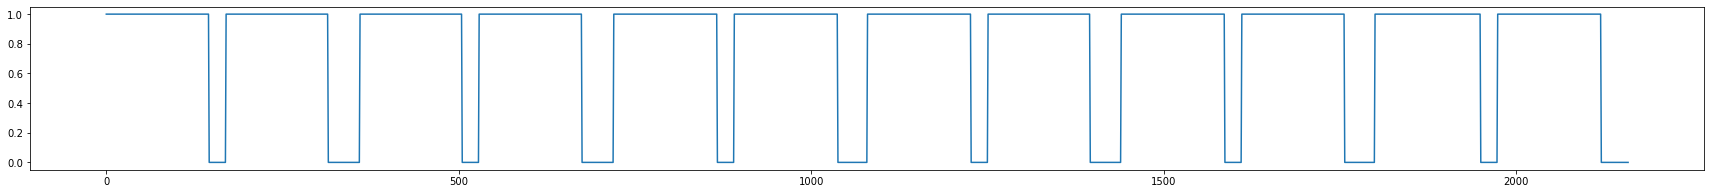

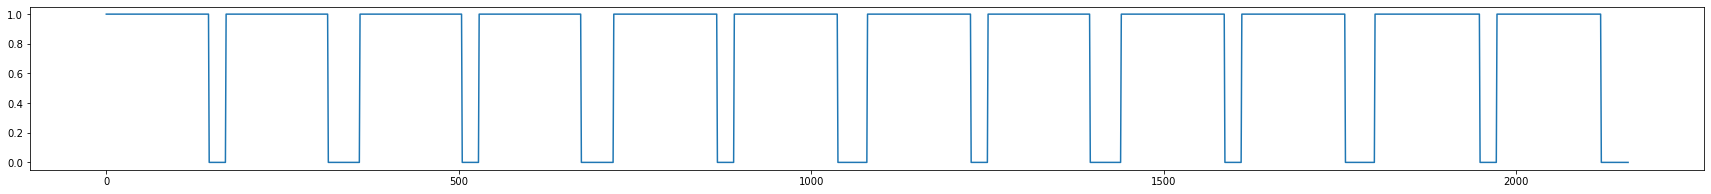

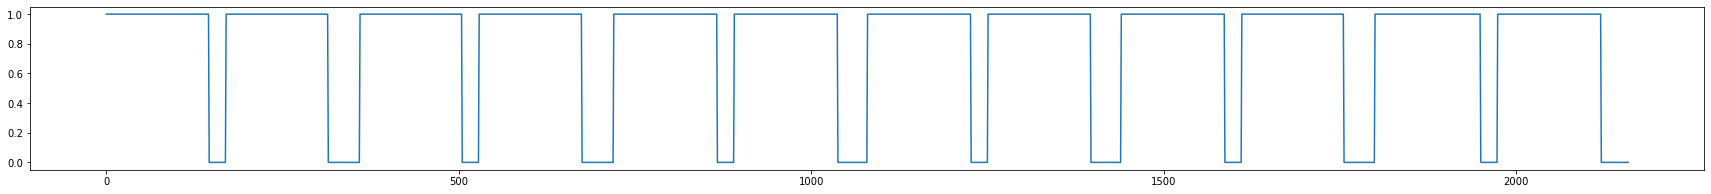

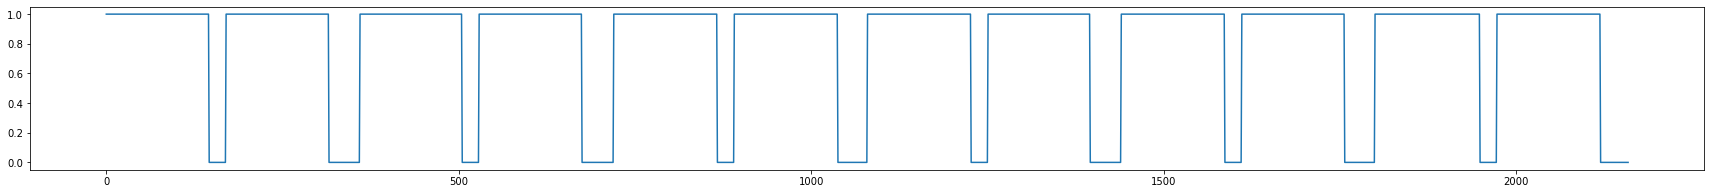

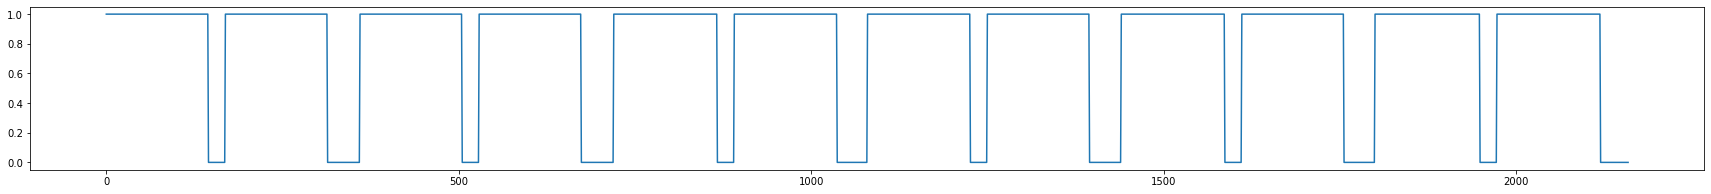

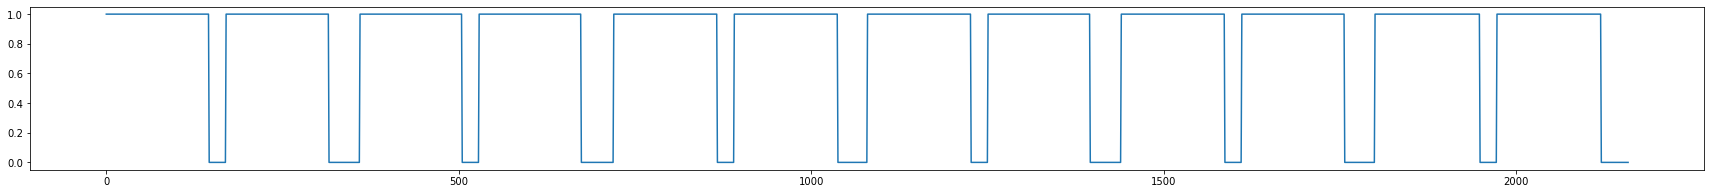

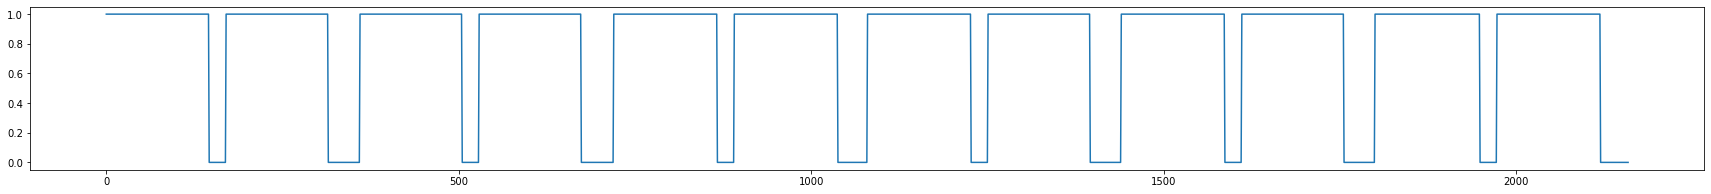

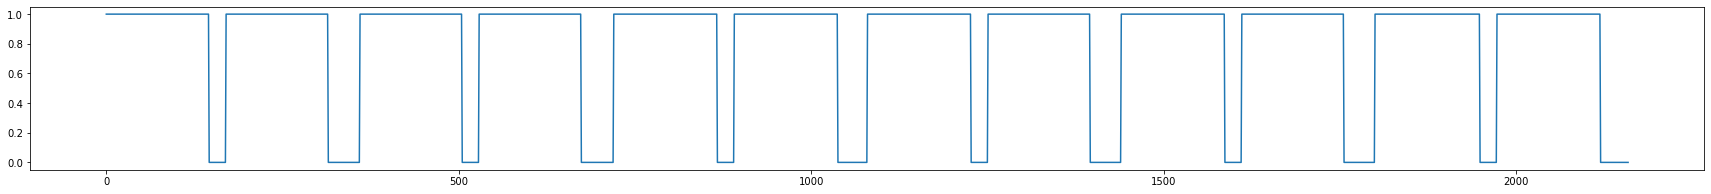

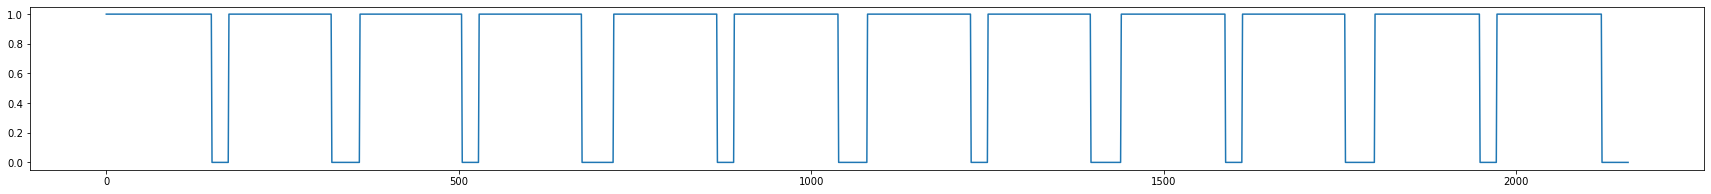

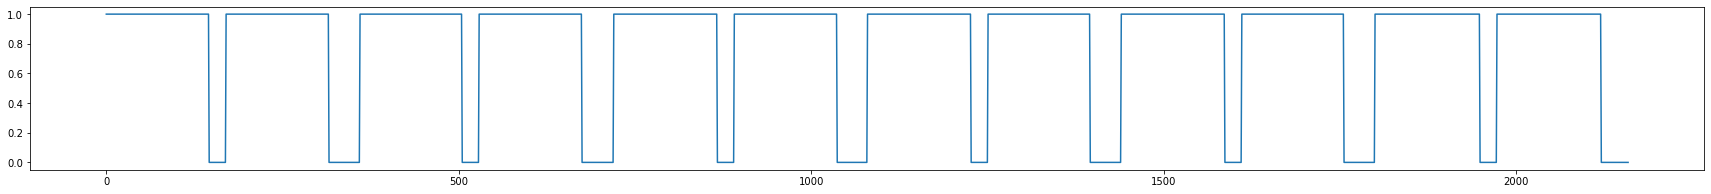

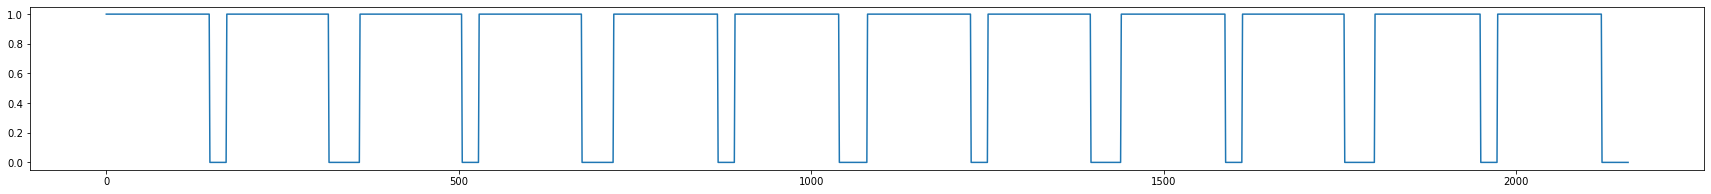

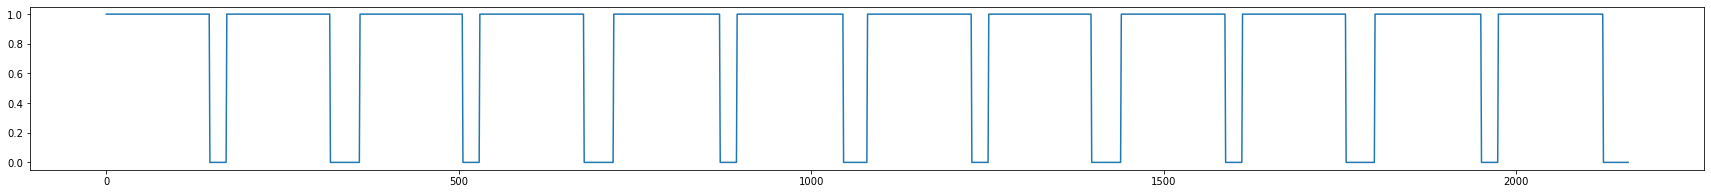

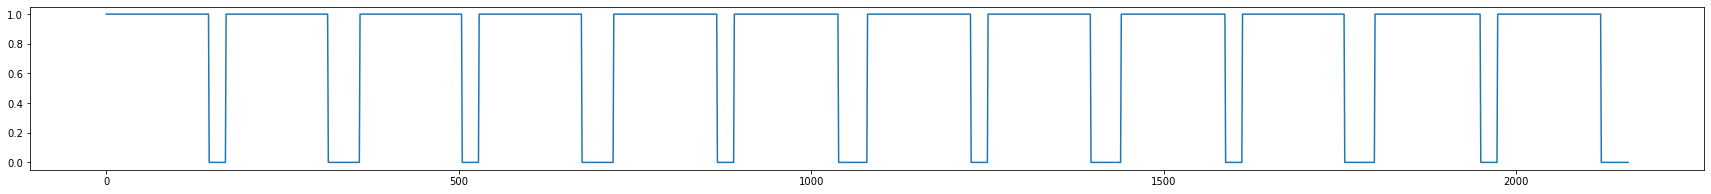

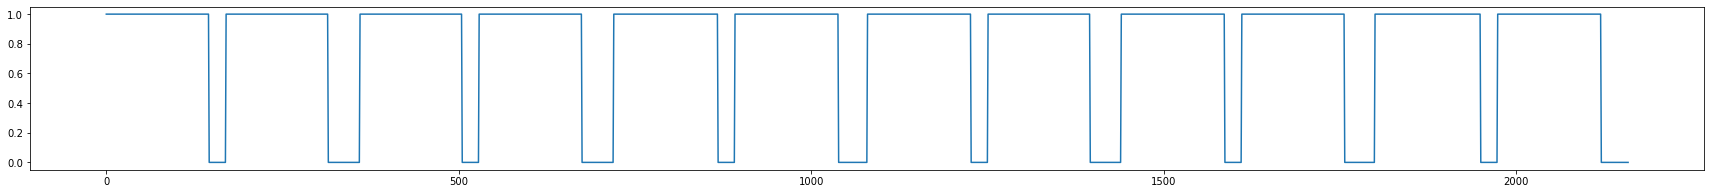

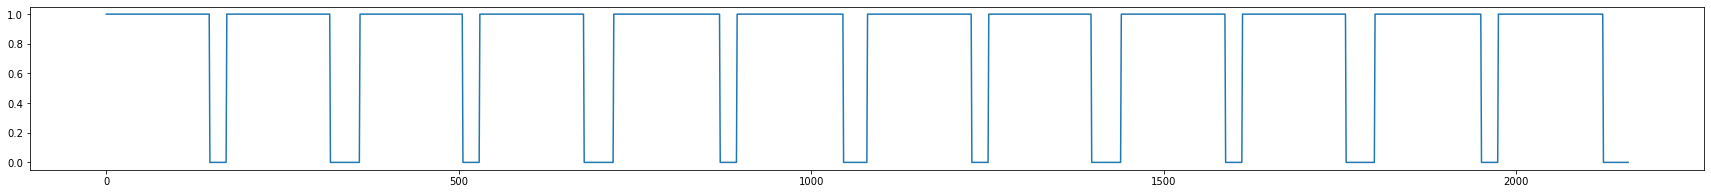

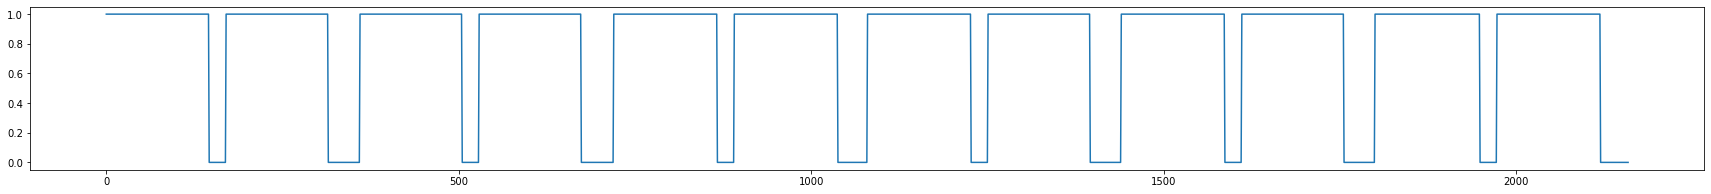

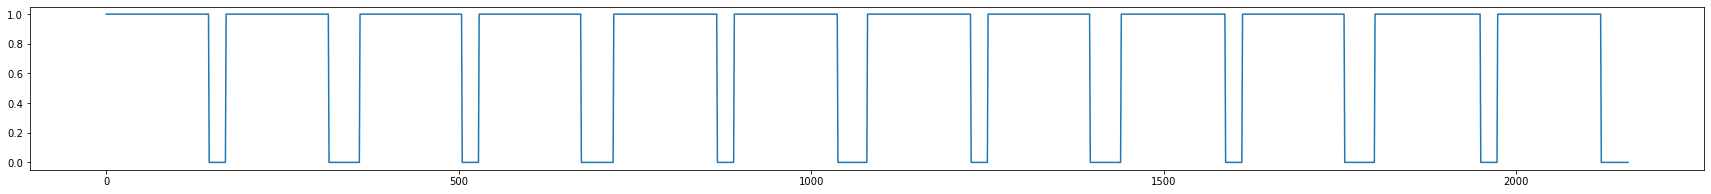

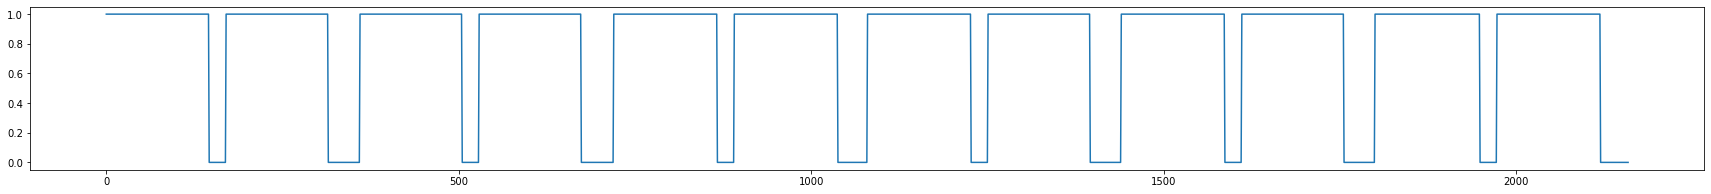

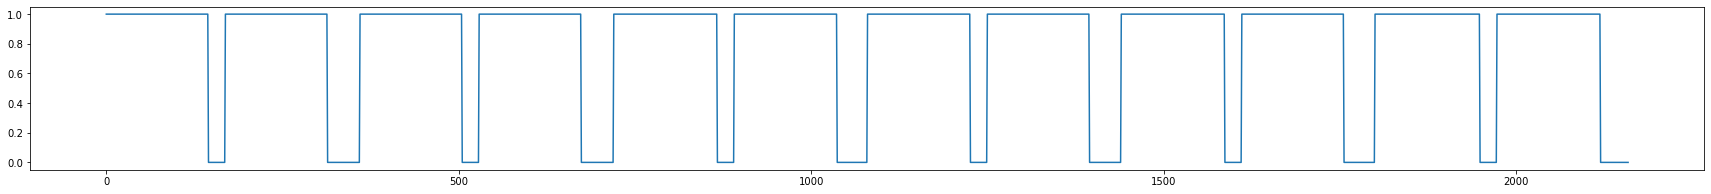

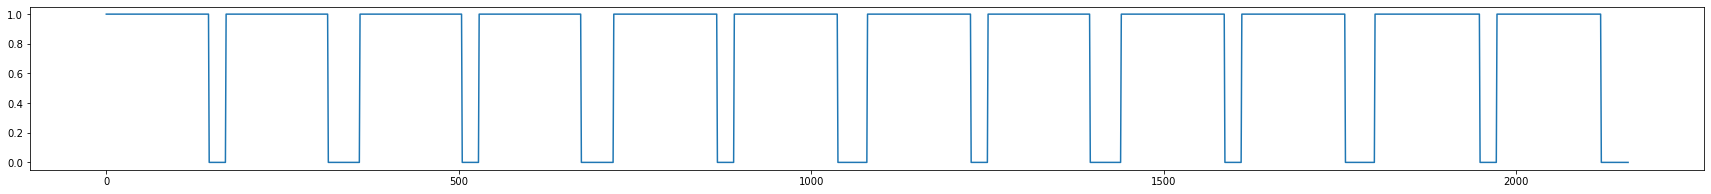

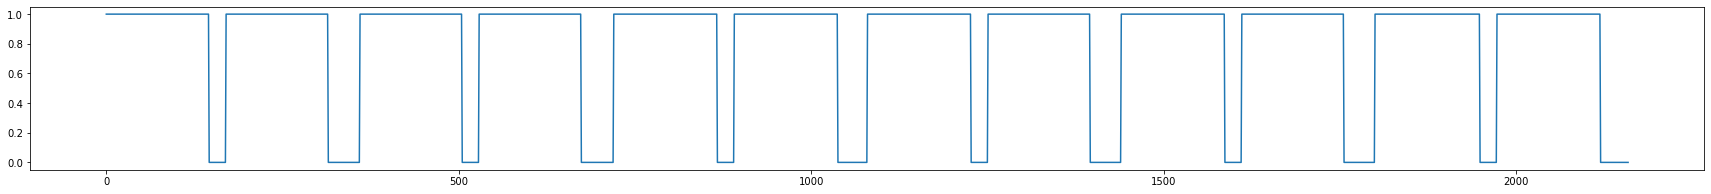

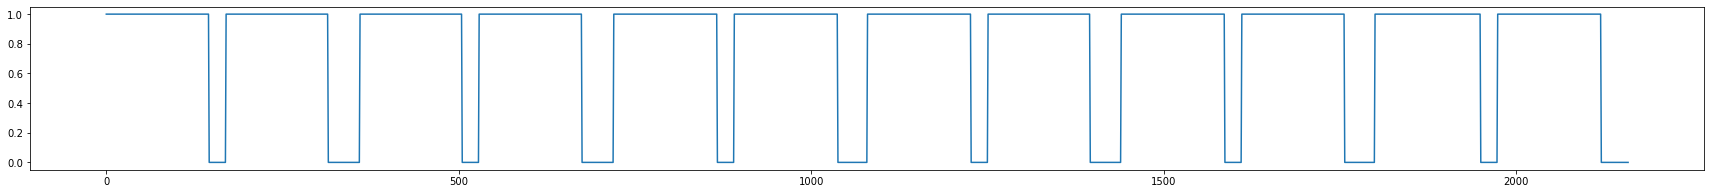

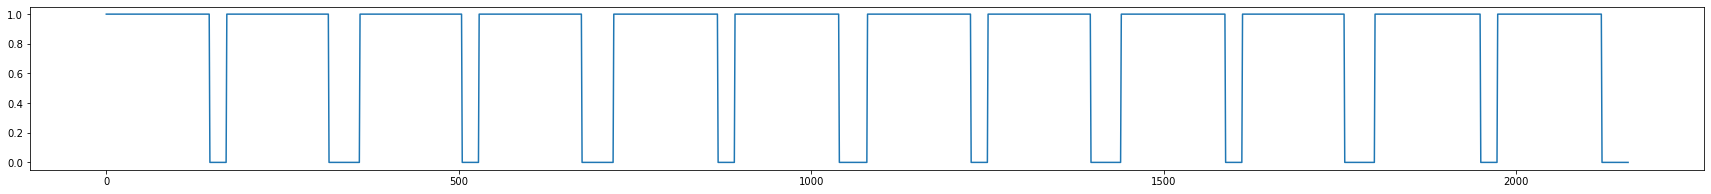

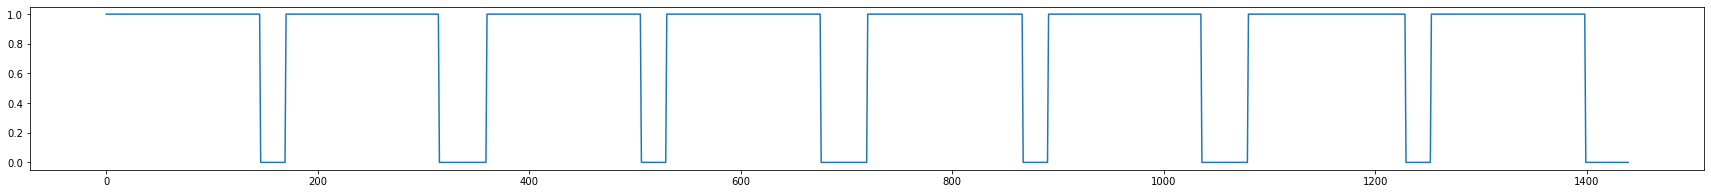

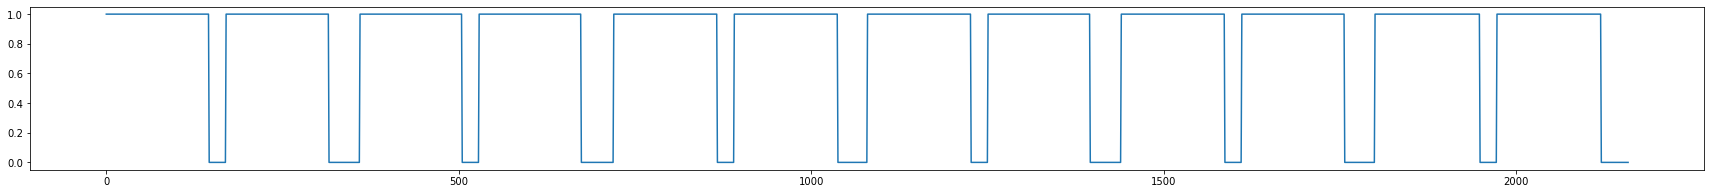

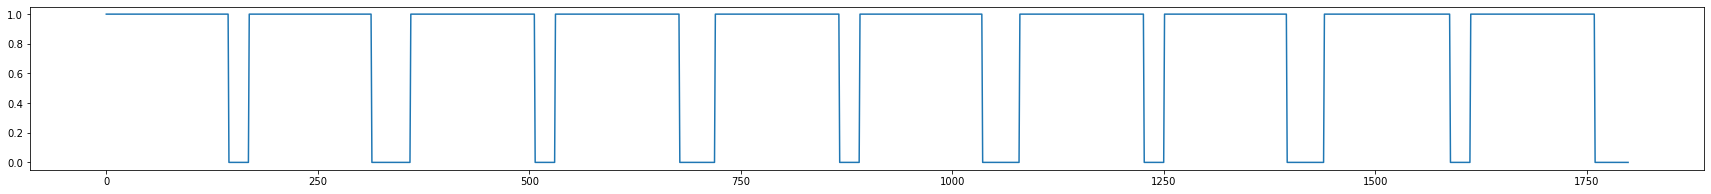

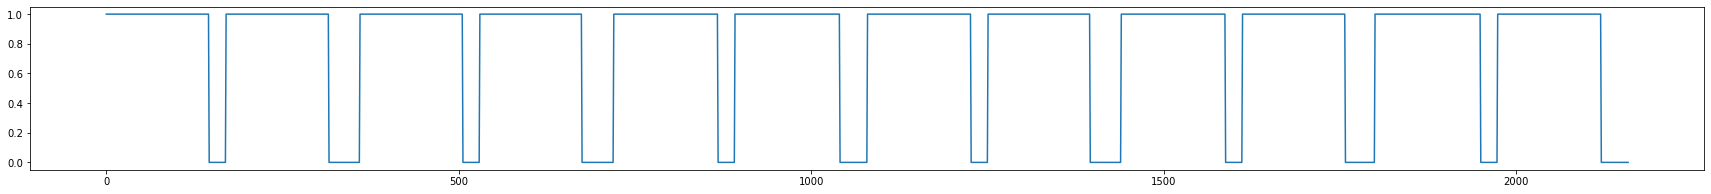

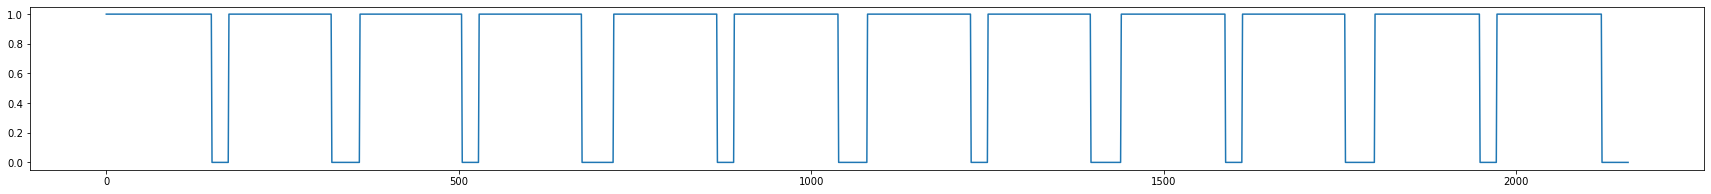

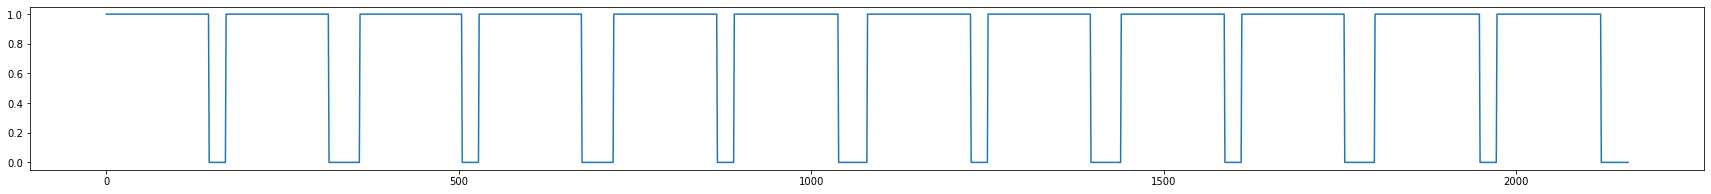

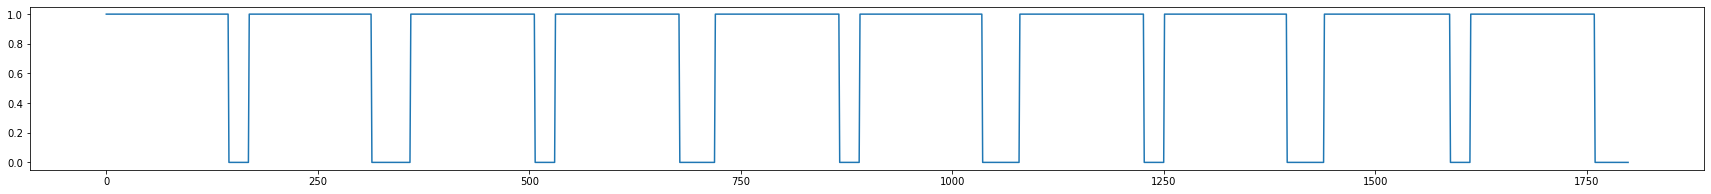

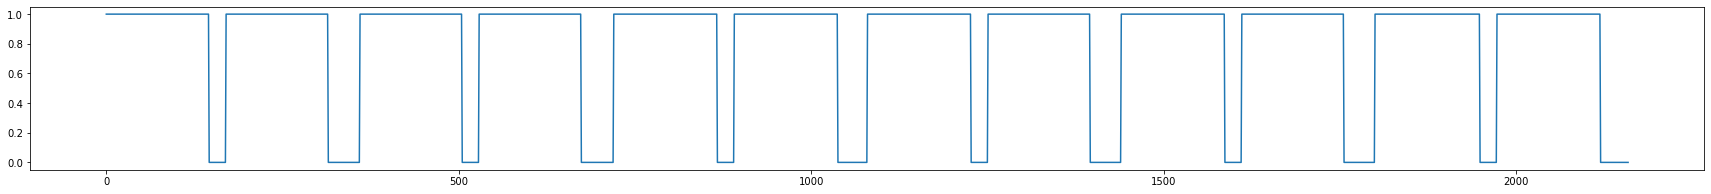

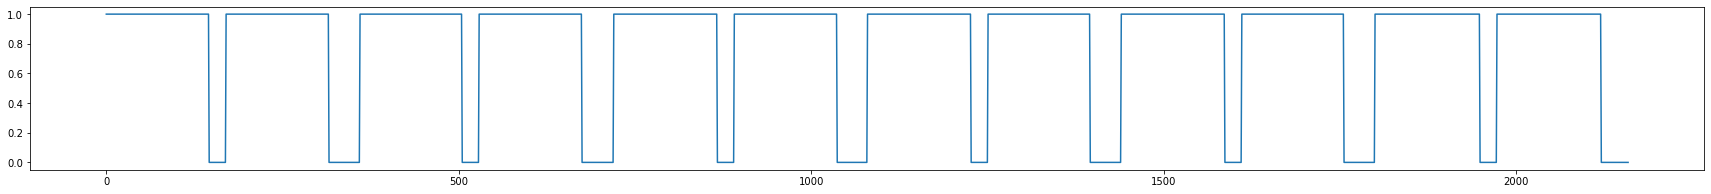

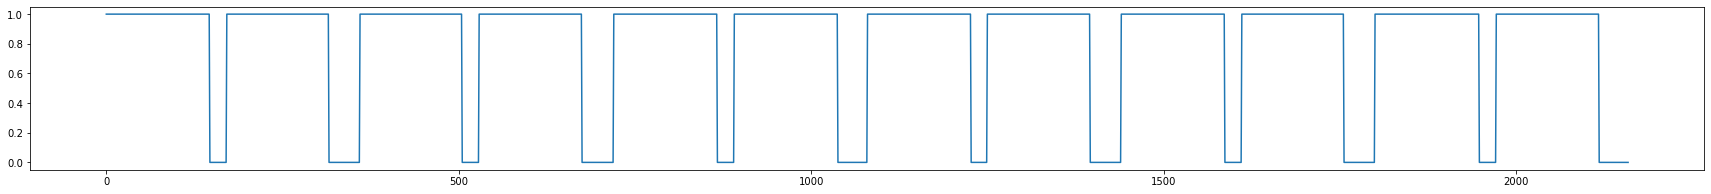

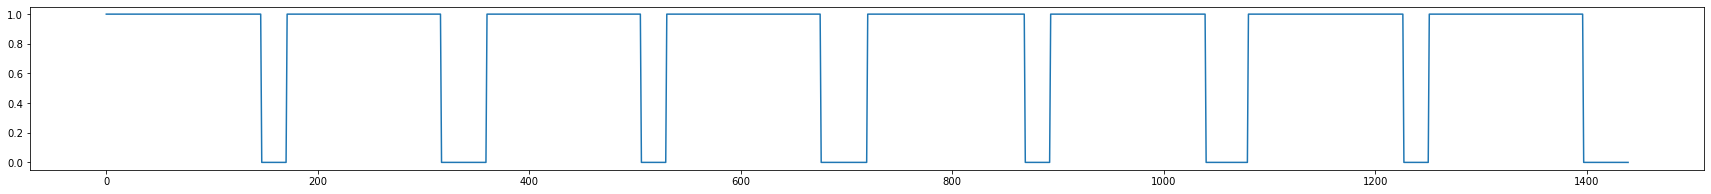

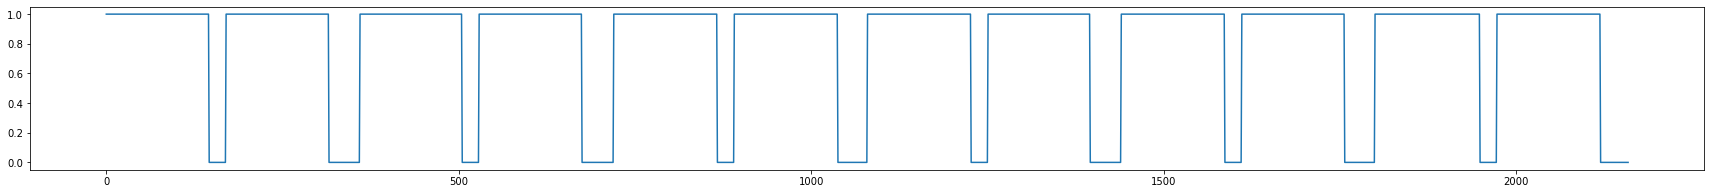

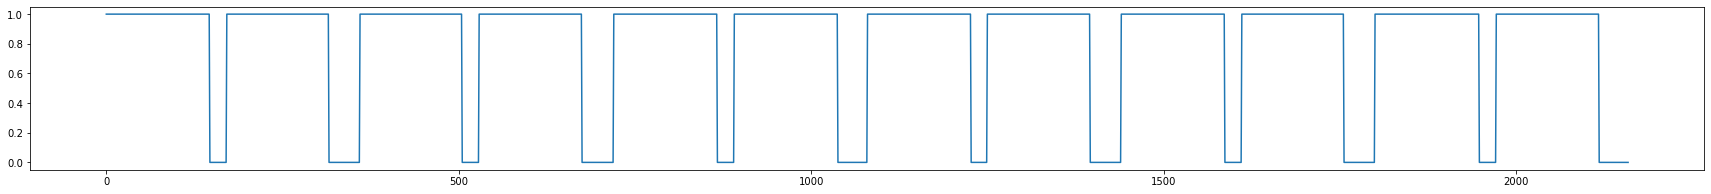

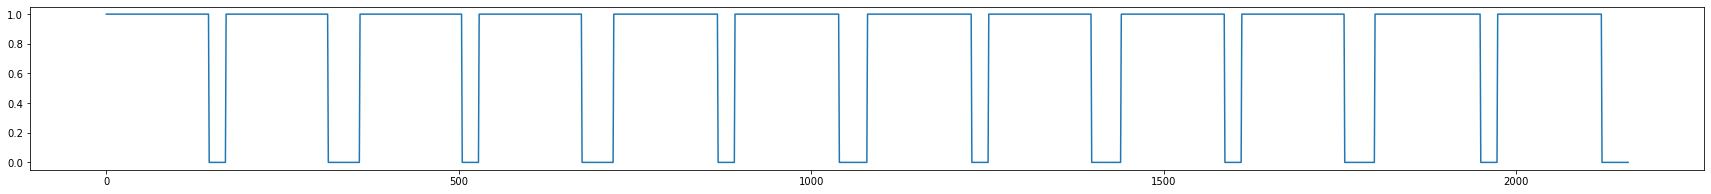

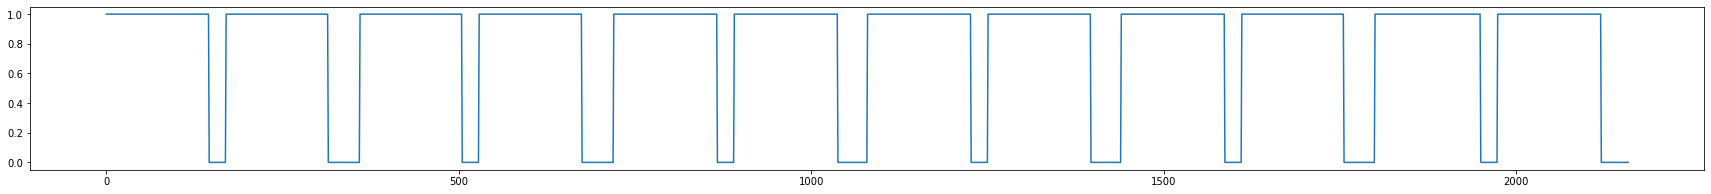

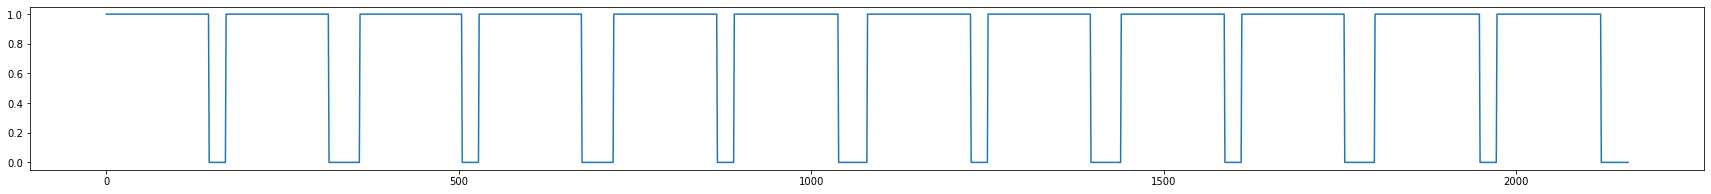

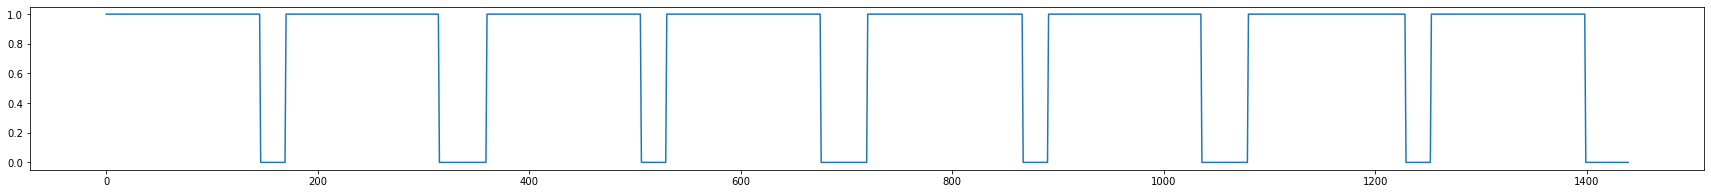

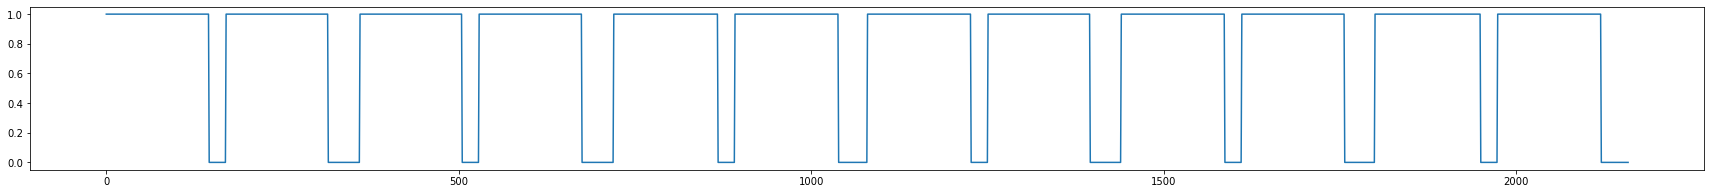

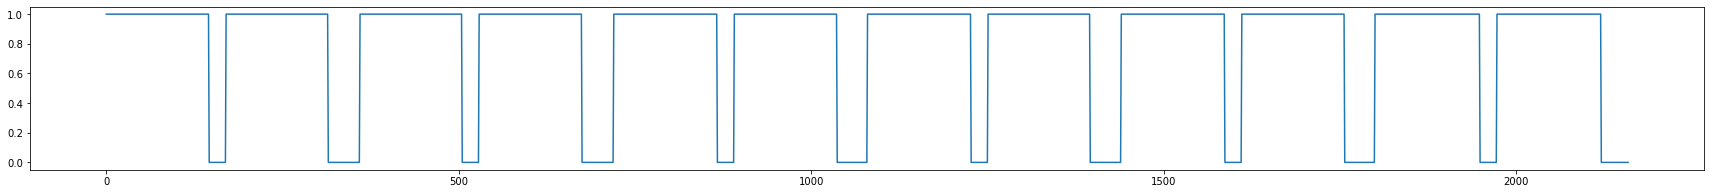

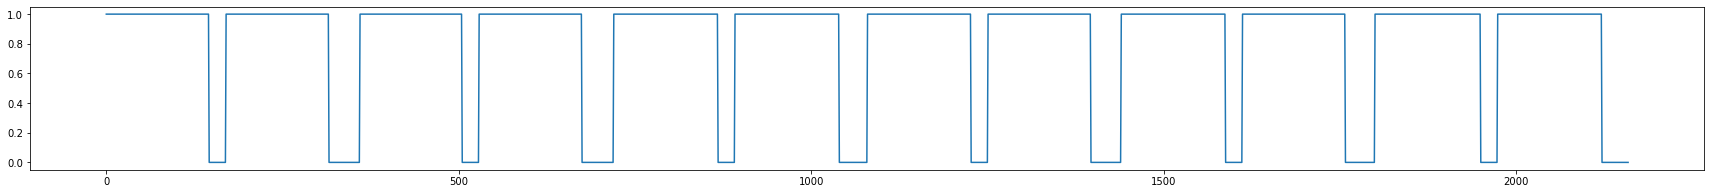

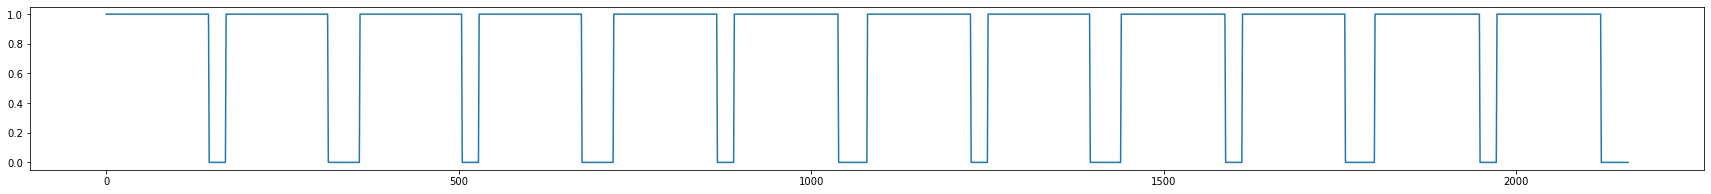

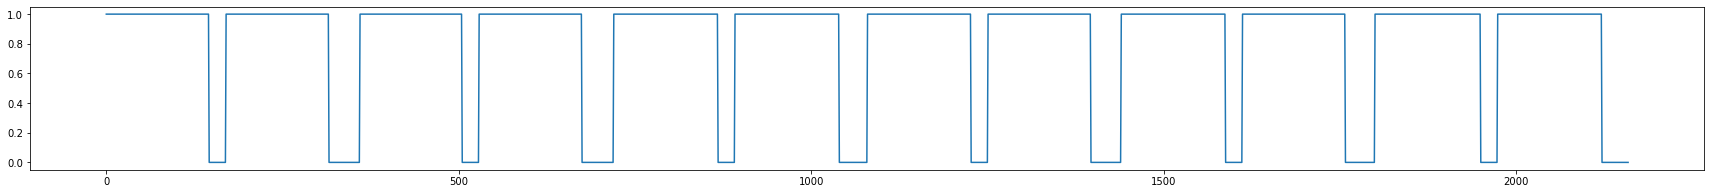

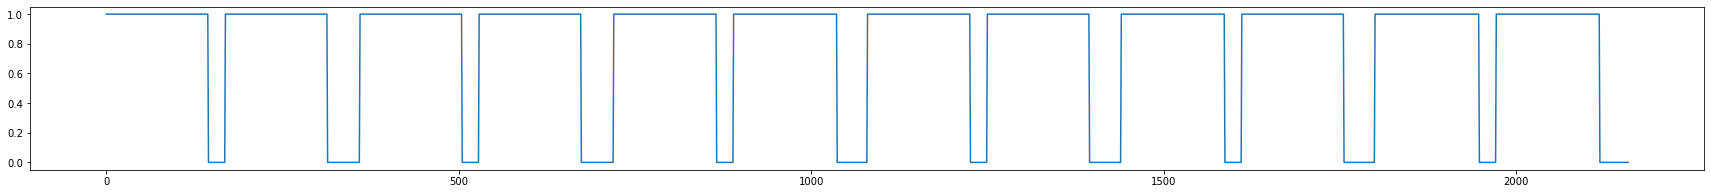

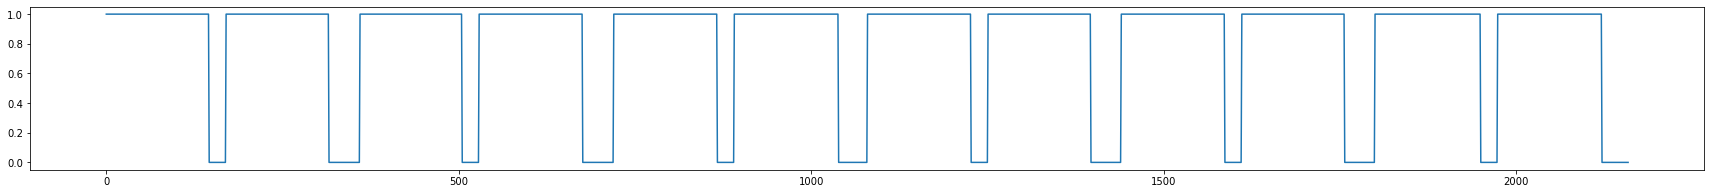

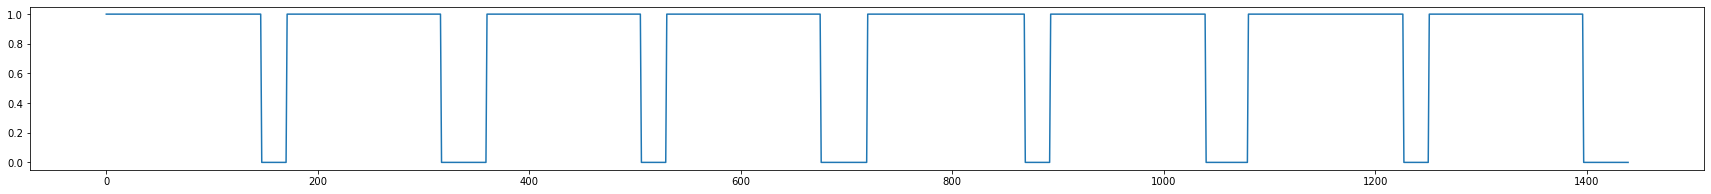

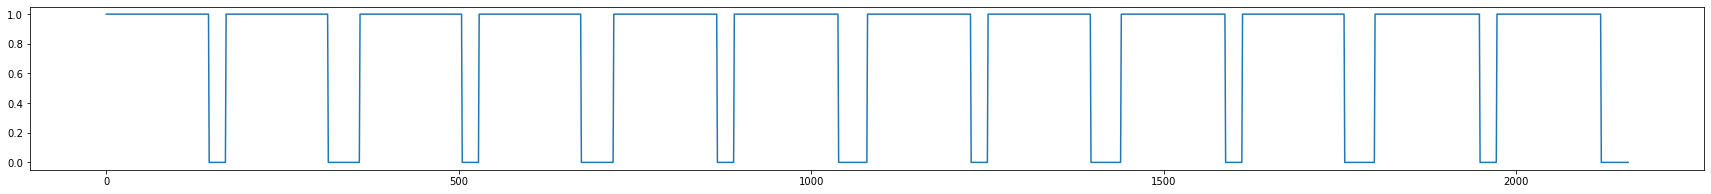

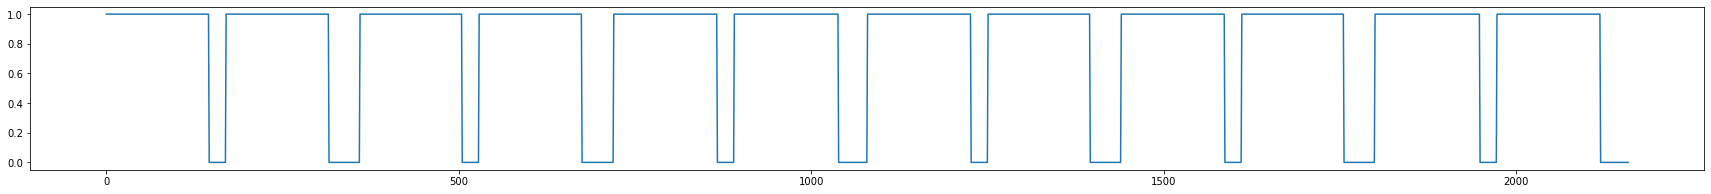

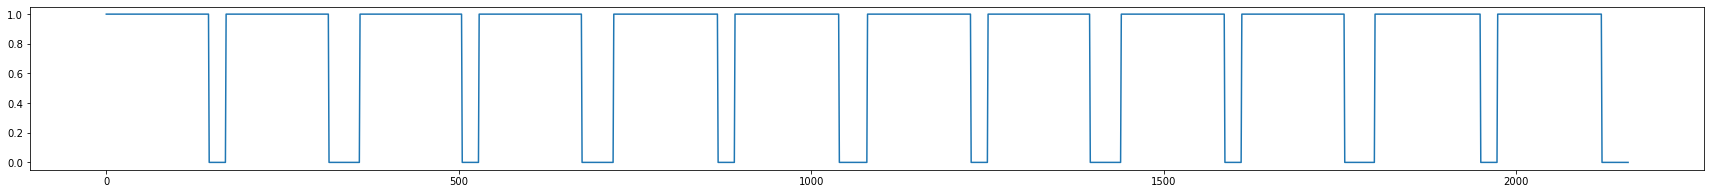

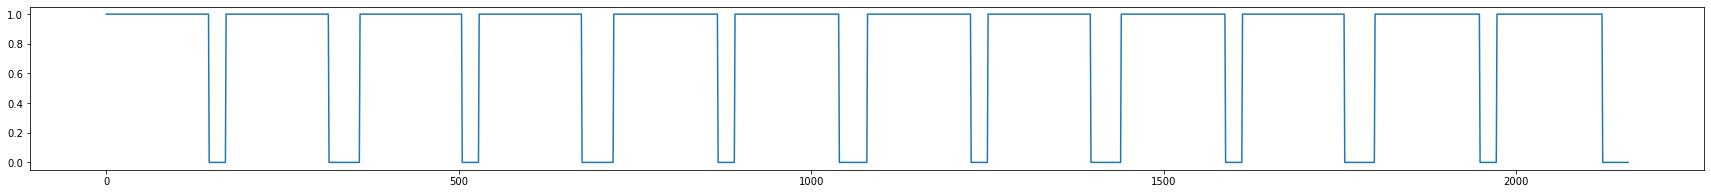

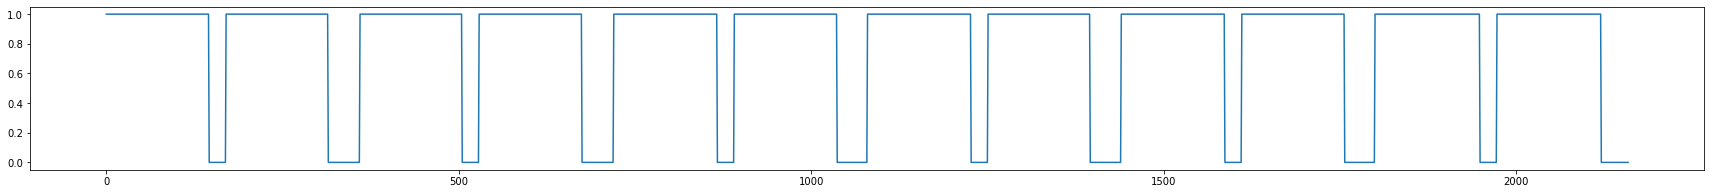

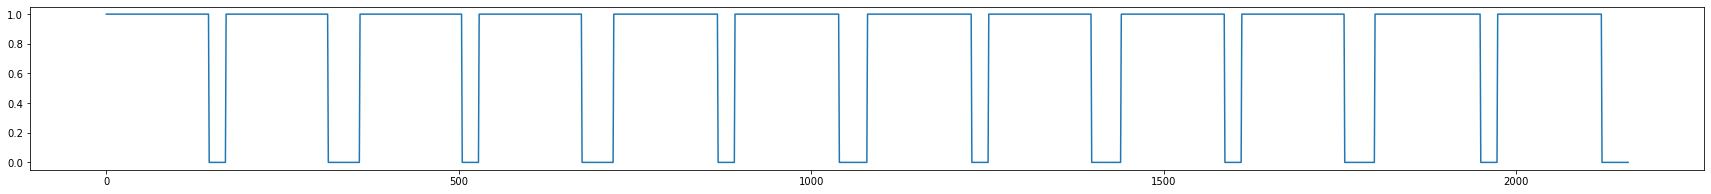

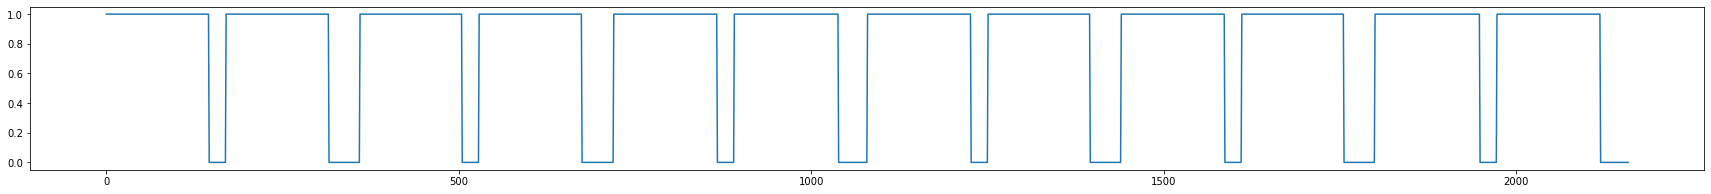

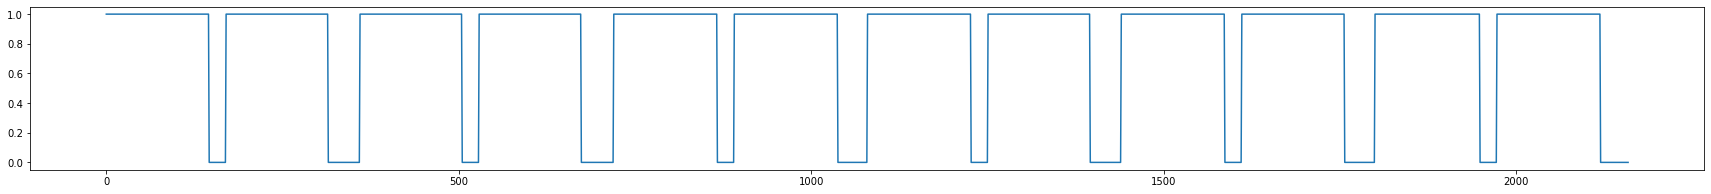

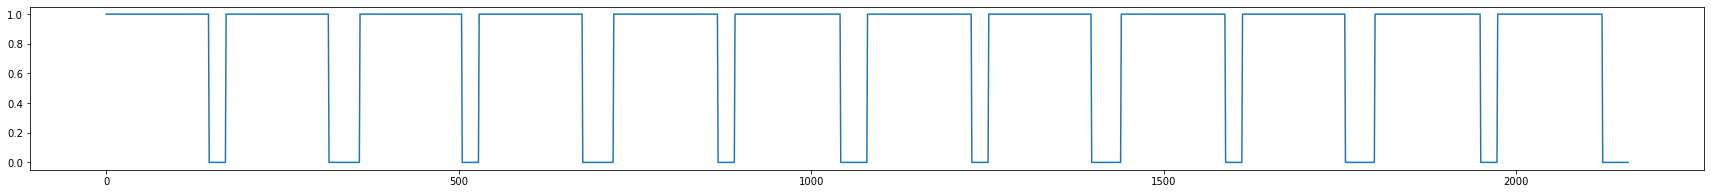

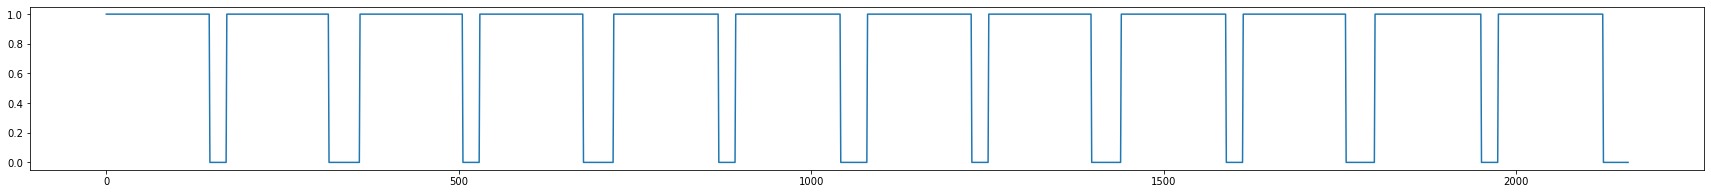

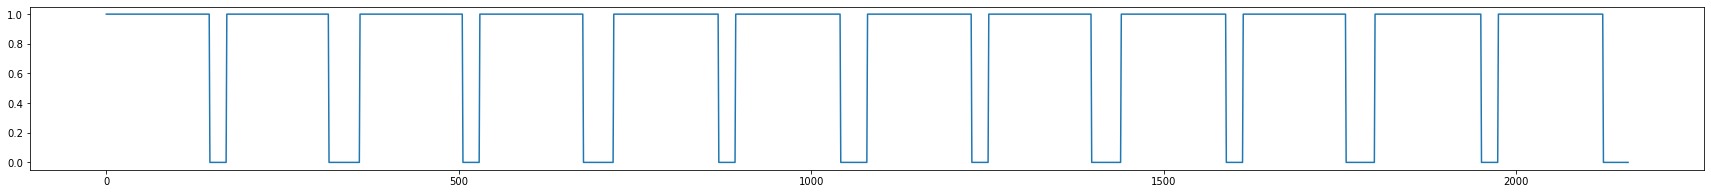

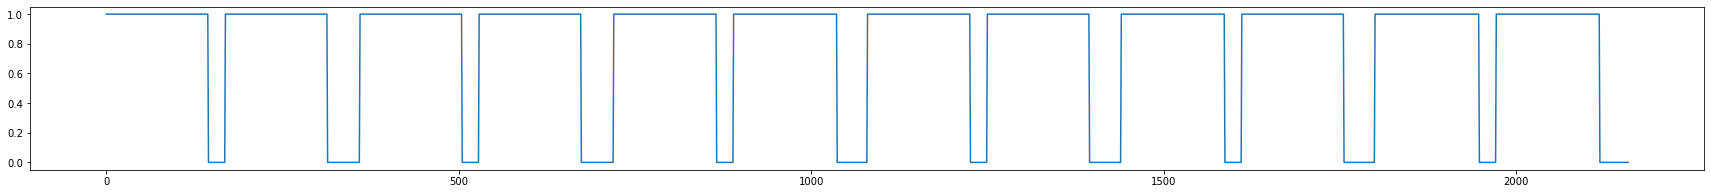

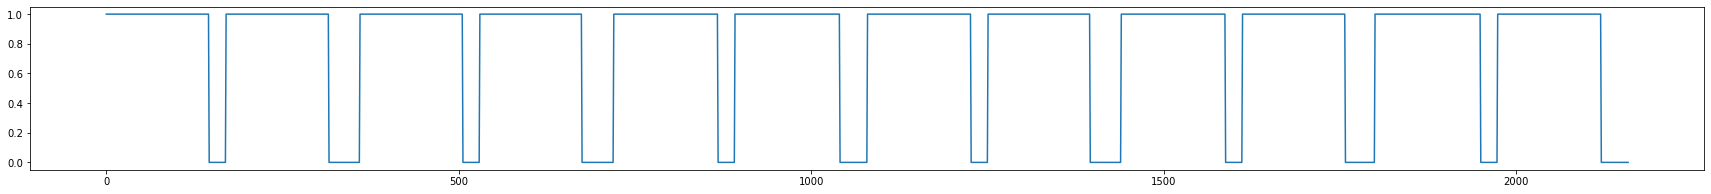

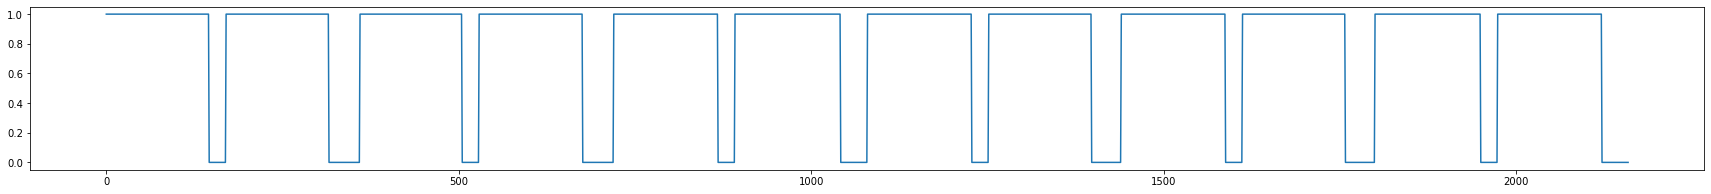

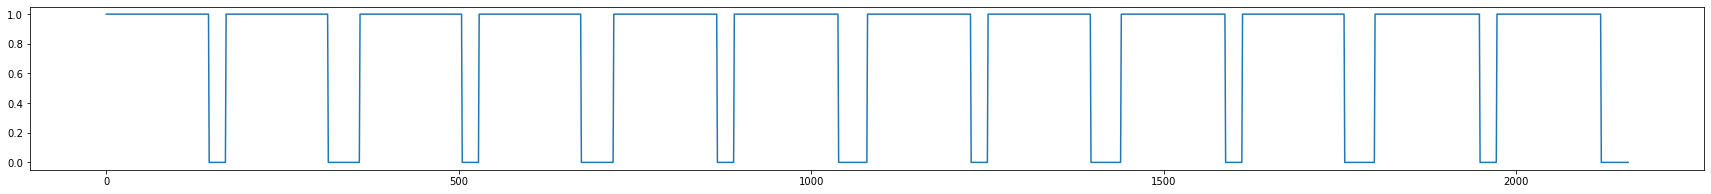

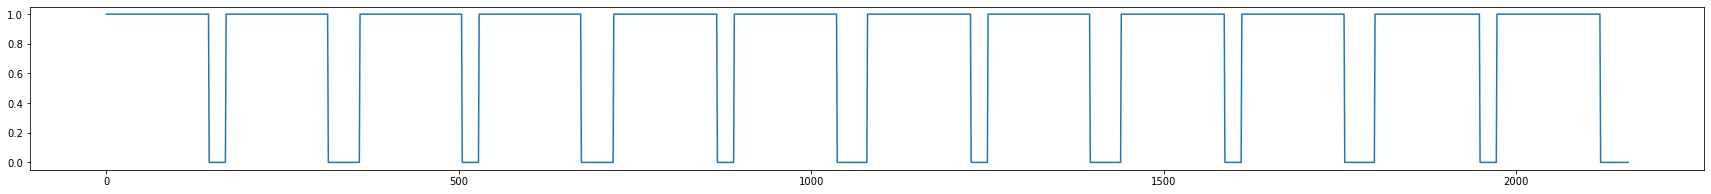

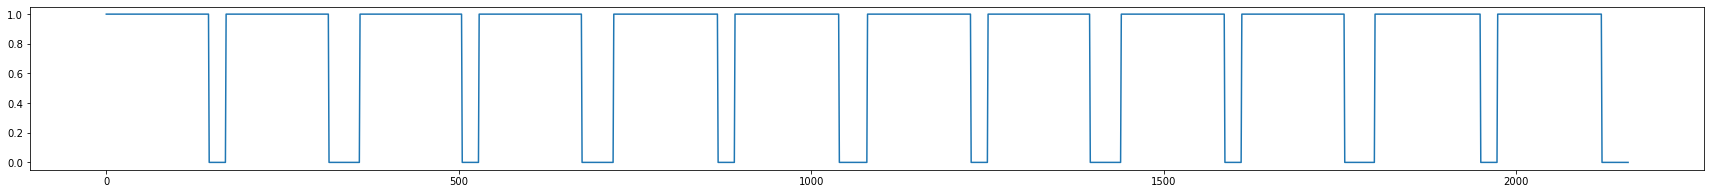

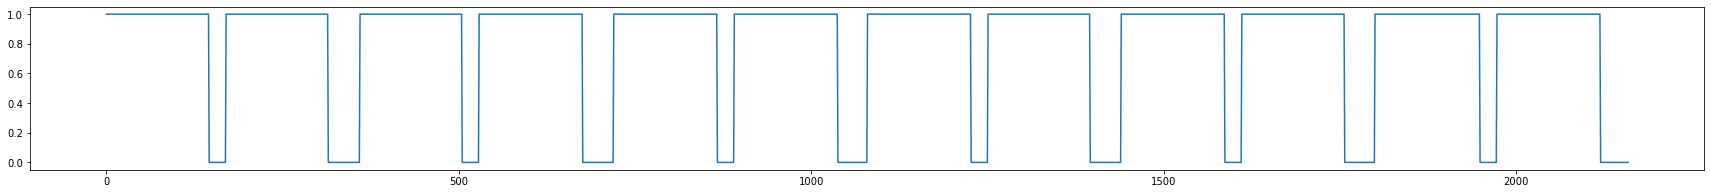

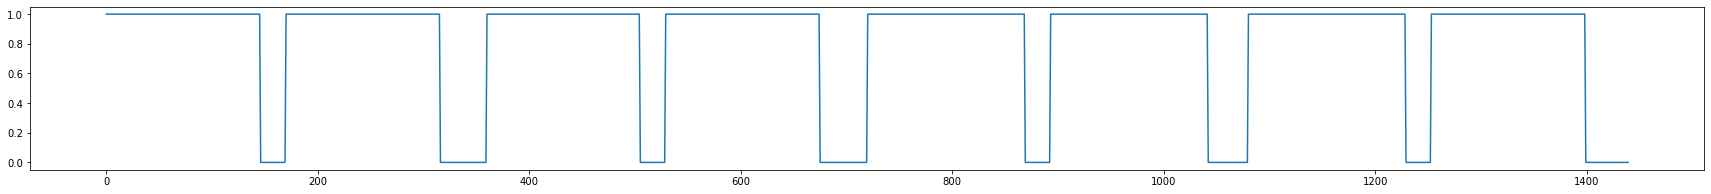

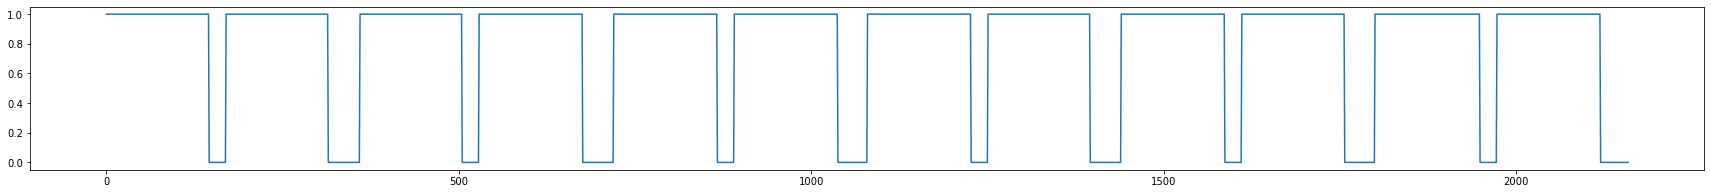

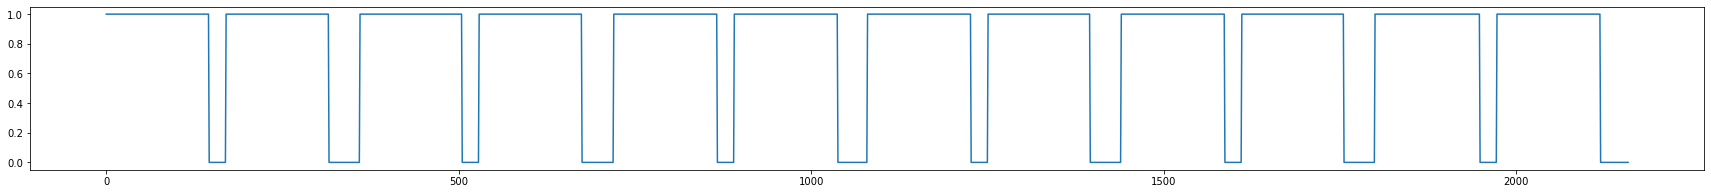

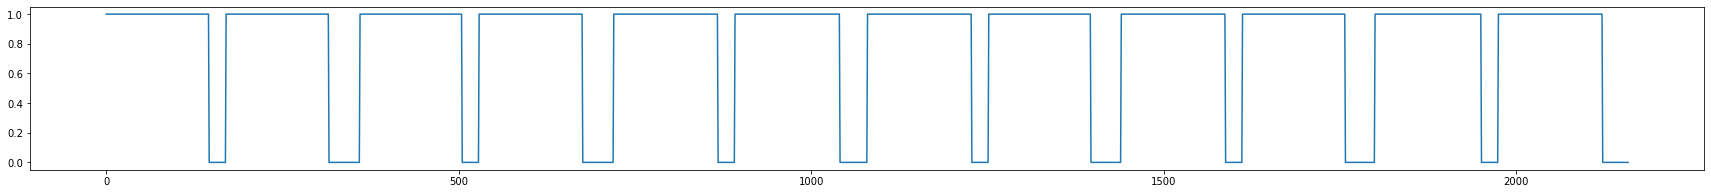

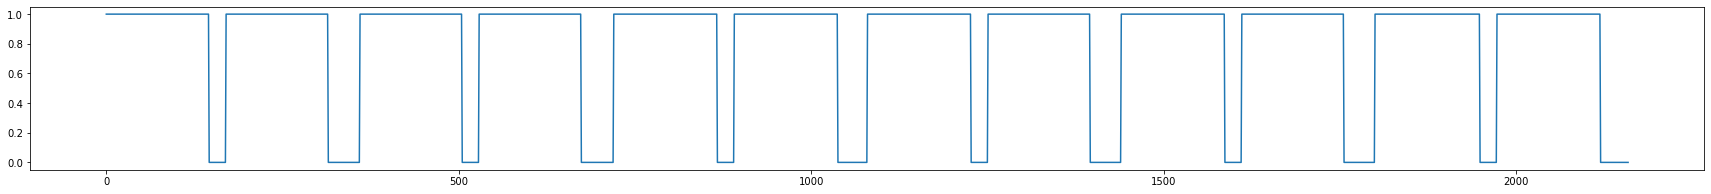

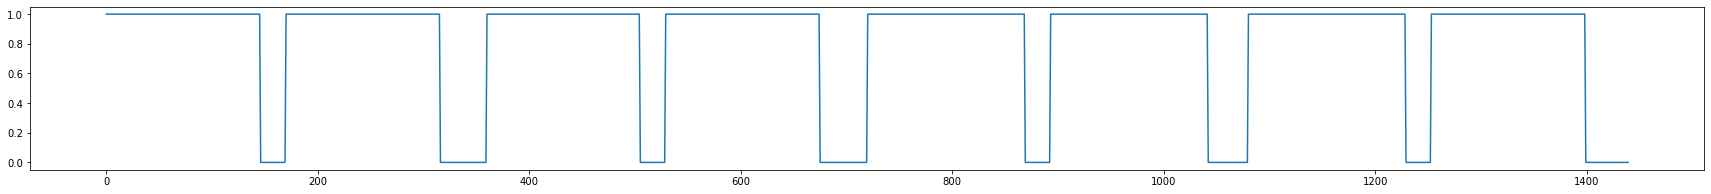

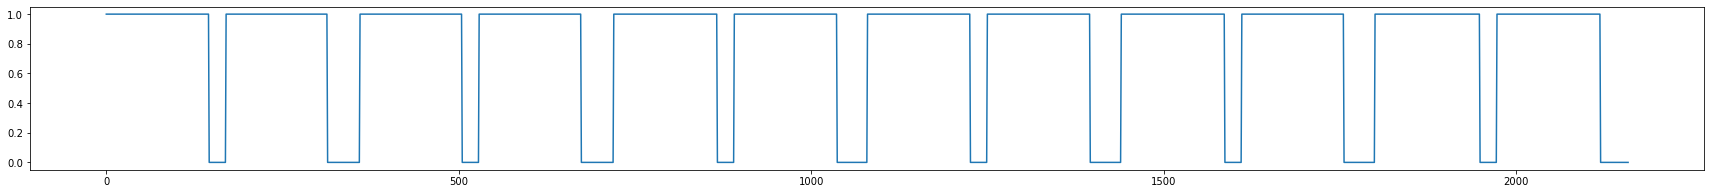

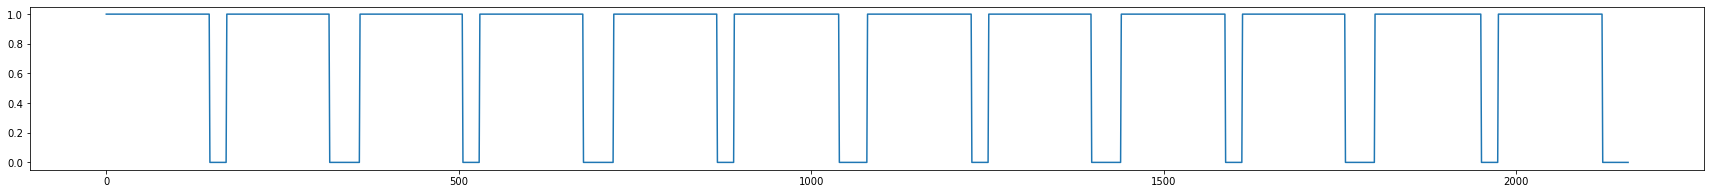

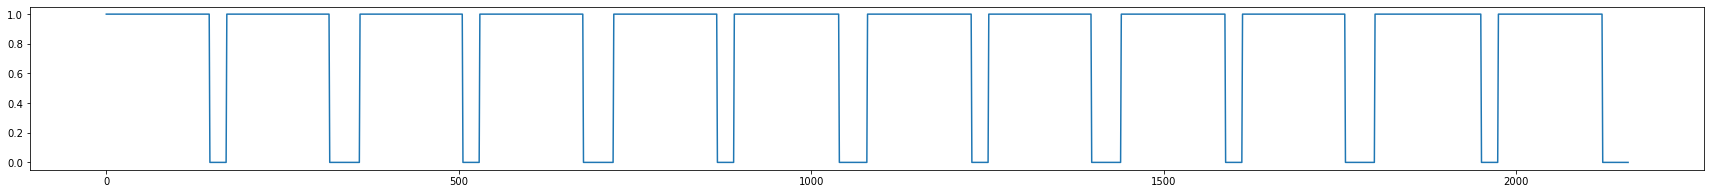

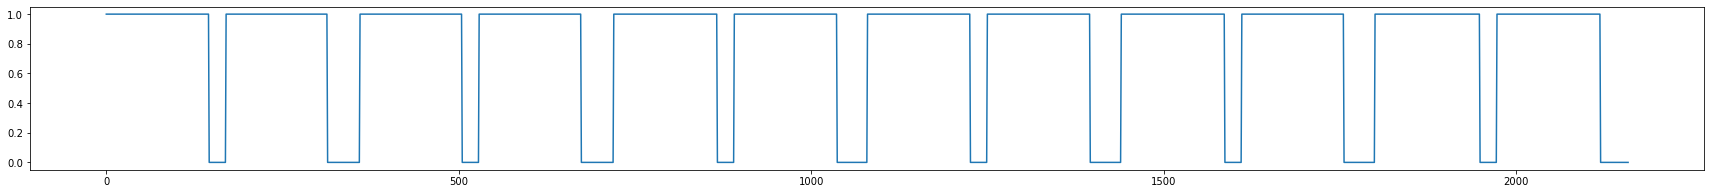

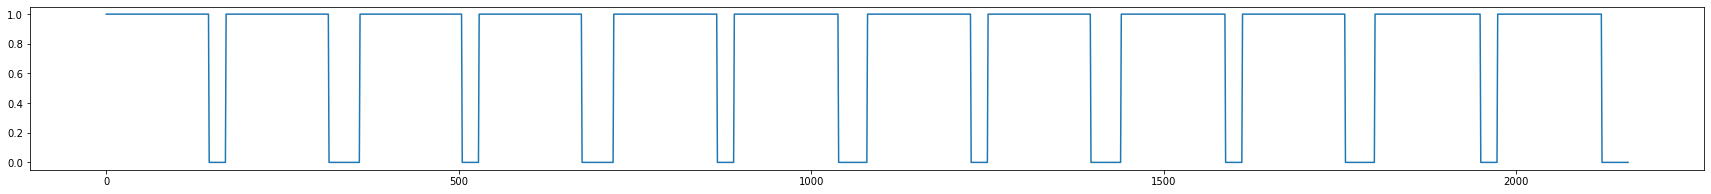

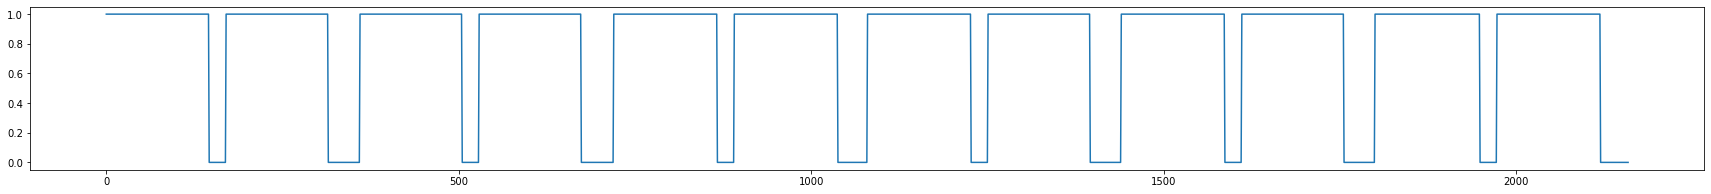

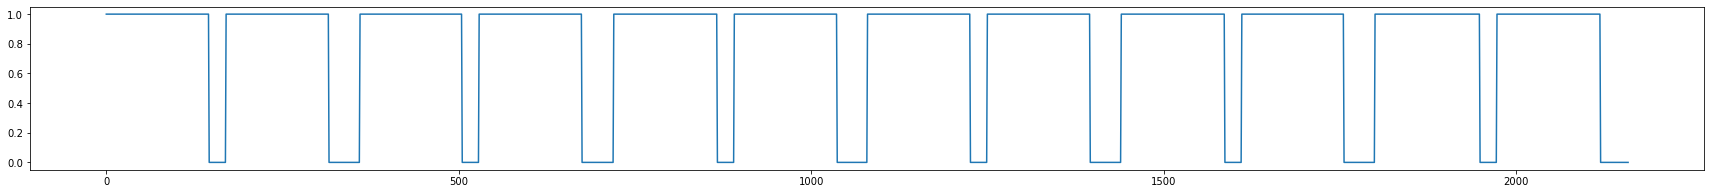

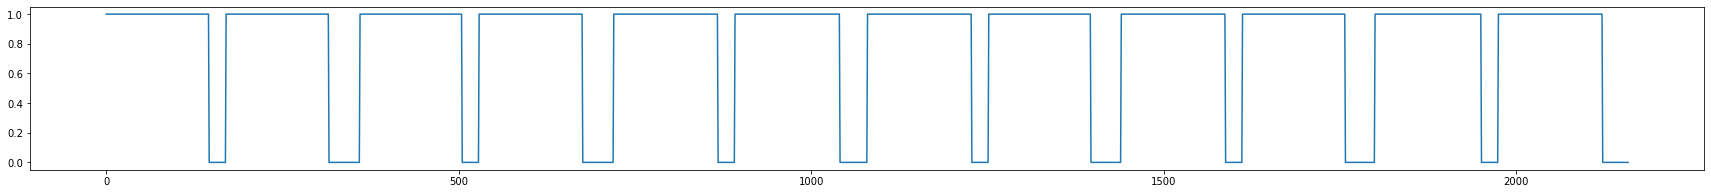

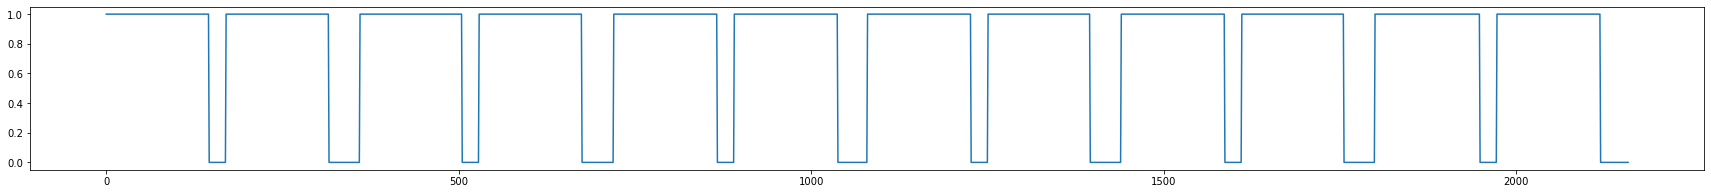

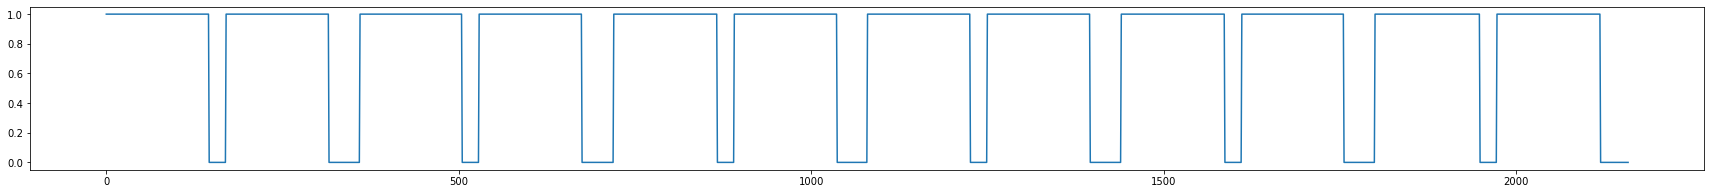

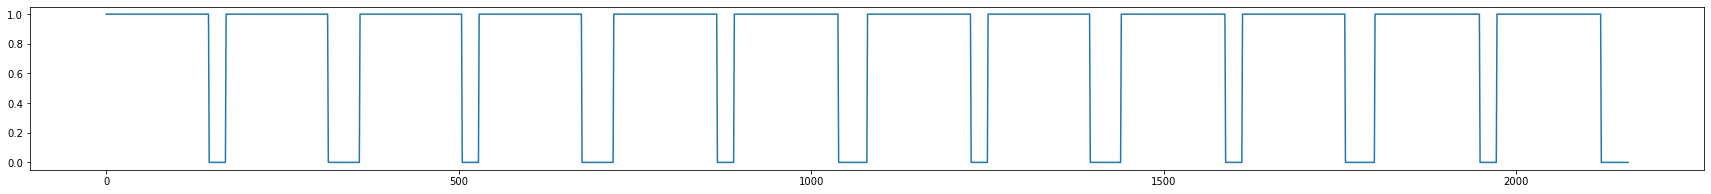

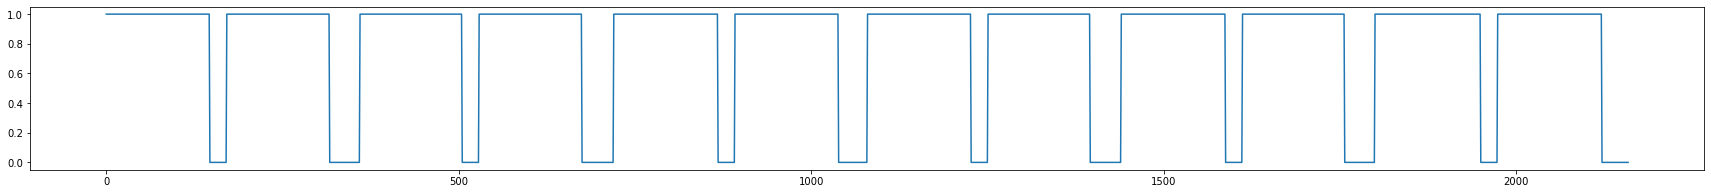

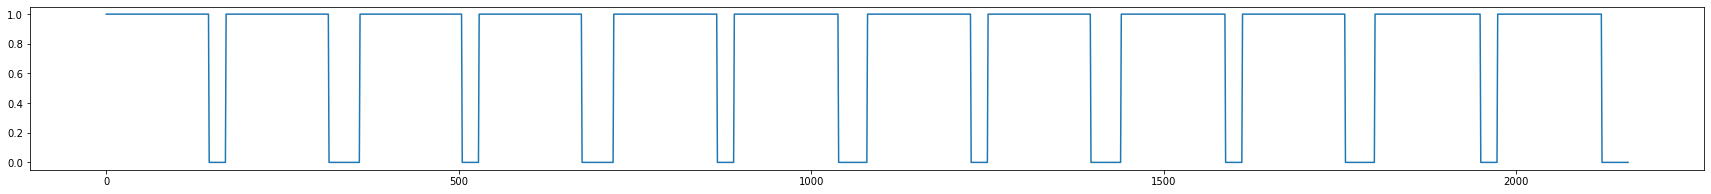

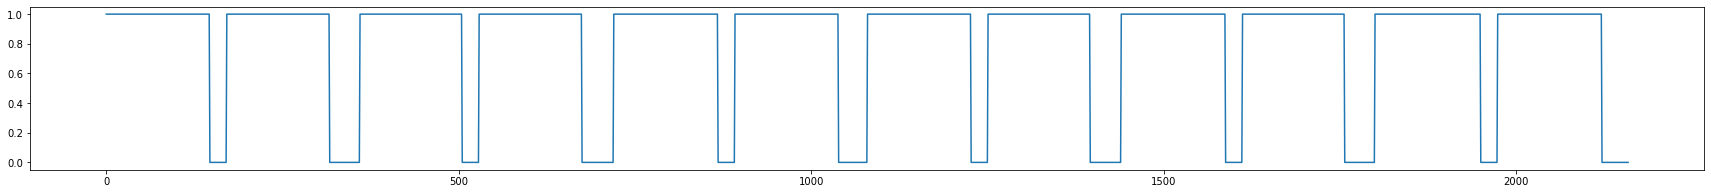

In [10]:
directory_path = f'./rSLDS_state_regressors/rslds_K{K}_D{D}_N{N}_{num_subjs}subjs_emoprox_5null/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

subj_list = df1.pid.unique()
for pid in subj_list:
    print("pid",pid)
    df_subj = df1[df1.pid==pid]
    states_allruns = []
    for rid in range(6):
        # print("rid",rid)
        if df_subj[df_subj.rid.isin([rid])].empty: continue
        states_run = -1*np.ones_like(df_subj.block_mask.values[0])
        block_masks = [df_subj[(df_subj.rid==rid)&(df_subj.block==i)].block_mask.values[0] for i in [1,2]]
        states = [df_subj[(df_subj.rid==rid)&(df_subj.block==i)].discrete_states.values[0] for i in [1,2]]
        for idx_block in range(2): states_run[block_masks[idx_block]] = np.roll(states[idx_block], np.random.randint(states[idx_block].shape[0]))
        
        states_allruns.append(states_run)
    states_allruns = np.hstack(states_allruns)
    
    fig=plt.figure(figsize=(30,3))    
    res = np.zeros_like(states_allruns)
    for idx_state in range(K):
        subj_state_regressor = (states_allruns==idx_state).astype('int')
        res += subj_state_regressor
        np.savetxt(directory_path + f'CON{pid}_state{idx_state}.txt',subj_state_regressor)
    plt.plot(res)
